# TVB-ANNarchy: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in ANNarchy

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_annarchy.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_annarchy")[0], "data")
simulation_mode = "rs" # "stim"
outputs_path = os.path.join(work_path, "outputs/outputs_Izhikevich_annarchy")
sim_mode_path = os.path.join(outputs_path, "TVBcortex", simulation_mode)
config = Config(output_base=sim_mode_path)
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# % loadedParams ={
# %     	'D1GPi_probs': probs[0],
# %     	'D1GPi_weights'  : weights[0],
# %     	'D2GPe_probs'   : probs[1],
# %     	'D2GPe_weights'  : weights[1],
# %     	'GPeSTN_probs'   : probs[2],
# %     	'GPeSTN_weights'  : weights[2],
# %     	'STNGPe_probs'   : probs[3],
# %     	'STNGPe_weights'  : weights[3],
# %     	'STNGPi_probs'   : probs[4],
# %     	'STNGPi_weights' : weights[4],
# %     	'GPeGPi_probs'   : probs[5],
# %     	'GPeGPi_weights'  : weights[5],
# %     	'GPeGPe_probs'   : probs[6],
# %     	'GPeGPe_weights'  : weights[6],
# %     	'GPiGPi_probs'   : probs[7],
# %     	'GPiGPi_weights'  : weights[7],
# %     	'GPiThal_probs'   : probs[8],
# %     	'GPiThal_weights'  : weights[8],
# %     	'ThaliSN_probs'   : probs[9],
# %     	'ThaliSN_weights'  : weights[9],
# %     	'ThaldSN_probs'   : probs[10],
# %     	'ThaldSN_weights'  : weights[10],
# %     	'dSNdSN_probs'   : probs[11],
# %     	'dSNdSN_weights'  : weights[11],
# %     	'iSNiSN_probs'   : probs[12],
# %     	'iSNiSN_weights'  : weights[12],
# %     	'CdSN_probs'   : probs[13],
# %     	'CdSN_weights'  : weights[13],
# %     	'CiSN_probs'   : probs[14],
# %     	'CiSN_weights'  : weights[14],
# %     	'CSTN_probs'   : probs[15],
# %     	'CSTN_weights'  : weights[15],
# %     	'V1Inh_probs'    : probs[16],
# %     	'V1Inh_weights'  : weights[16],
# %     	'InhV1_probs'    : probs[17],
# %     	'InhV1_weights'  : weights[17],
# %     	'InhInh_probs'   : probs[18],
# %     	'InhInh_weights'  : weights[18]}

import scipy.io as sio
conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
weights=sio.loadmat(os.path.join(conn_path,"OutputSim_Patient01.mat")) # weights start from index 19

# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))

weights_maith=weights["X"][0, 19:] # these are indices 19 till 37

BG_opt_matrix_weights[0, 1] = weights_maith[5]  
BG_opt_matrix_weights[0, 2] = weights_maith[2]
BG_opt_matrix_weights[1, 4] = weights_maith[8]
BG_opt_matrix_weights[2, 0] = weights_maith[3]
BG_opt_matrix_weights[2, 1] = weights_maith[4]
BG_opt_matrix_weights[3, 0] = weights_maith[1]
BG_opt_matrix_weights[3, 1] = weights_maith[0]
BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN

wGPeGPe = weights_maith[6]  # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]  # "GPi" -> "GPi" 
wdSNdSN = weights_maith[11] # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12] # "IiSN" -> "IiSN" 
wThiSN = weights_maith[9]   # "Eth" -> "IiSN" 


probs_maith=weights["X"][0, :19] # these are indices 0 till 18

pGPeGPi = probs_maith[5]  
pGPeSTN = probs_maith[2]
pGPiTh = probs_maith[8]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
piSNGPe = probs_maith[1]
pdSNGPi = probs_maith[0]
pThdSN = probs_maith[10] # Th --> dSN

pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN" 


Connections between Thalami removed!:
 [[0.6059682  0.        ]
 [0.         0.31177142]]
Removing BG -> Cortex connections with max:
5561.70581402219
Removing BG <- Cortex connections with max:
5202.36821426155

Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:


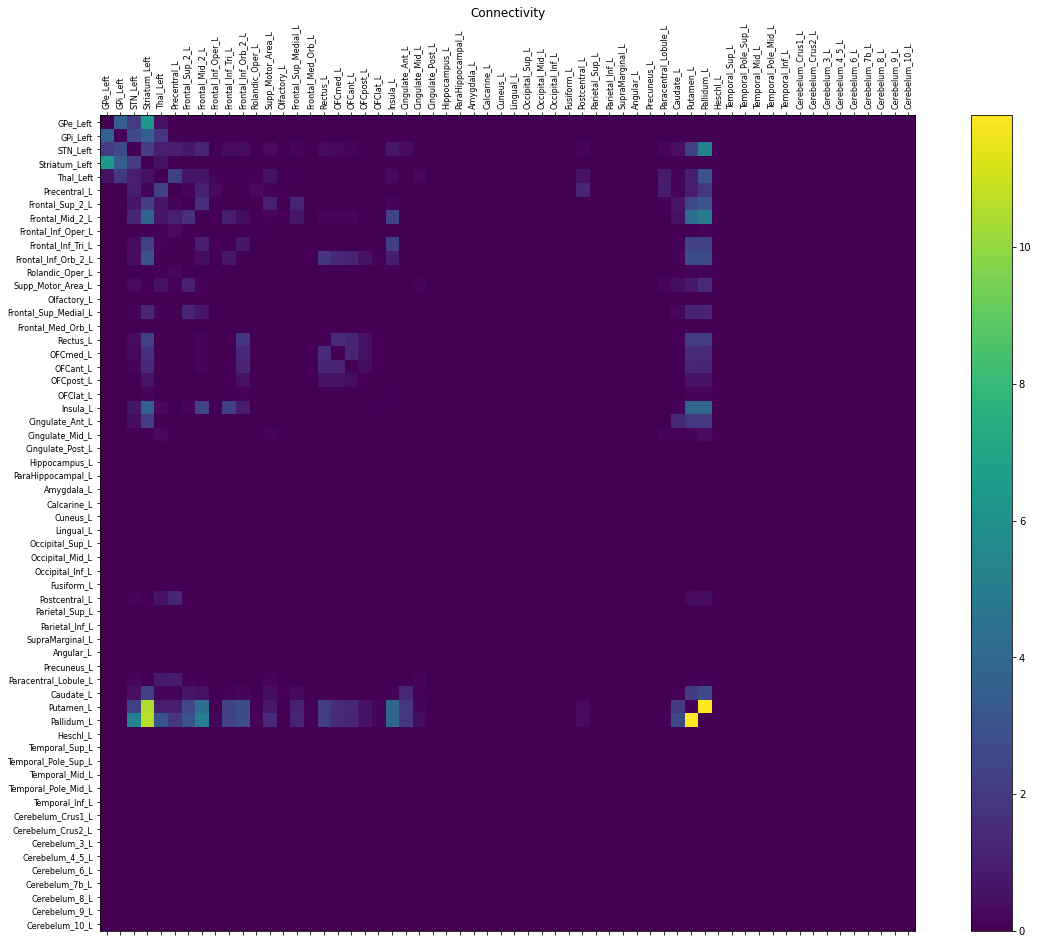

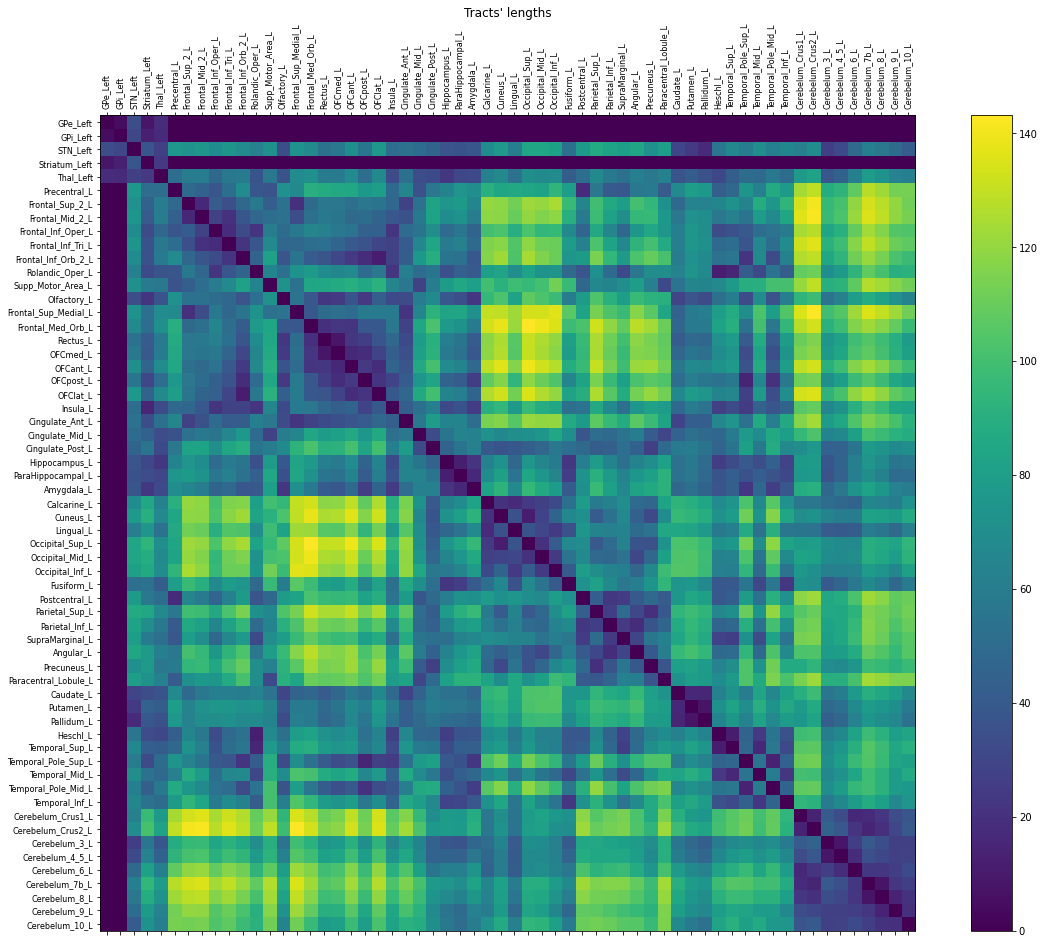

In [3]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# # ????Remove the second Thalamus????:
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
print("Connections between Thalami removed!:\n", wTVB[[8,9], :][:, inds_Th] / wTVB.max())
wTVB = np.delete(wTVB, inds_Th, axis=0)
wTVB = np.delete(wTVB, inds_Th, axis=1)
tlTVB = np.delete(tlTVB, inds_Th, axis=0)
tlTVB = np.delete(tlTVB, inds_Th, axis=1)
rlTVB = np.delete(rlTVB, inds_Th, axis=0)
cTVB = np.delete(cTVB, inds_Th, axis=0)

number_of_regions = len(rlTVB)
speed = np.array([4.0])
min_tt = speed.item() * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB, speed=speed)

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connLeft = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                        centres=connTVB.centres[sliceLeft],
                        weights=connTVB.weights[sliceLeft][:, sliceLeft],
                        tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft], 
                       speed=connTVB.speed)
connLeft.configure()

print("\nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:")
plotter.plot_tvb_connectivity(connLeft);



Left BG TVB network:


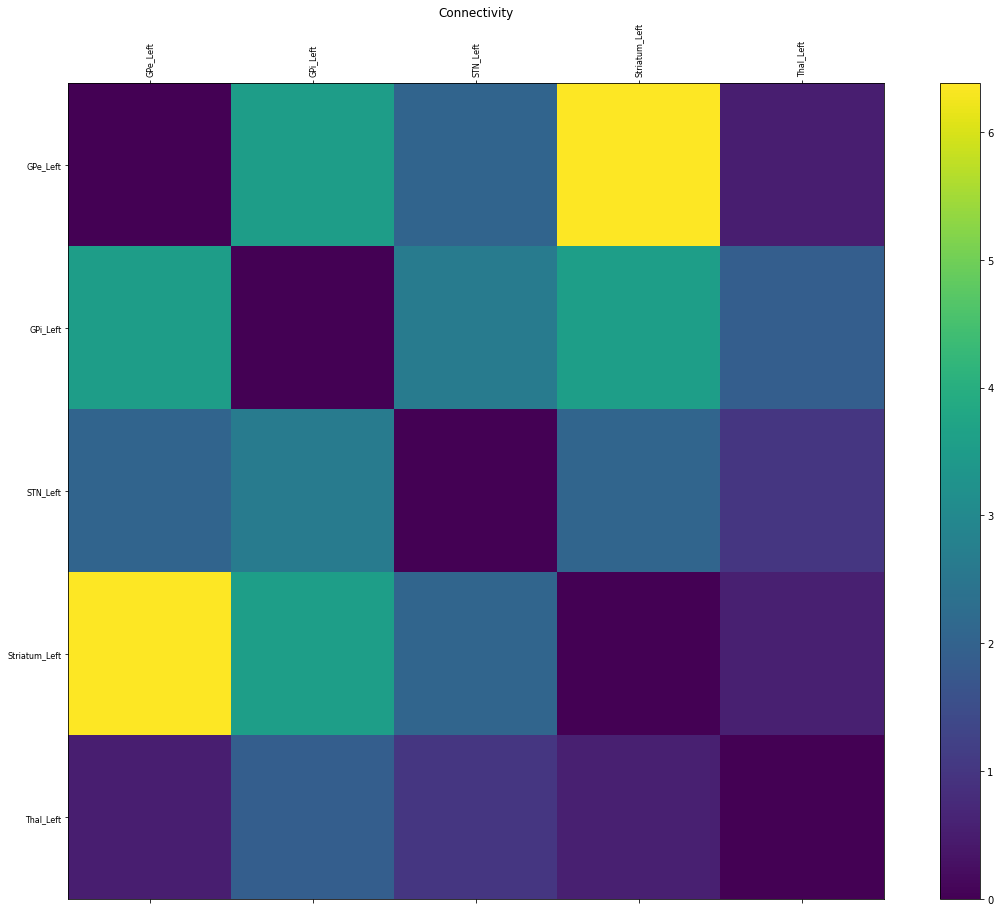

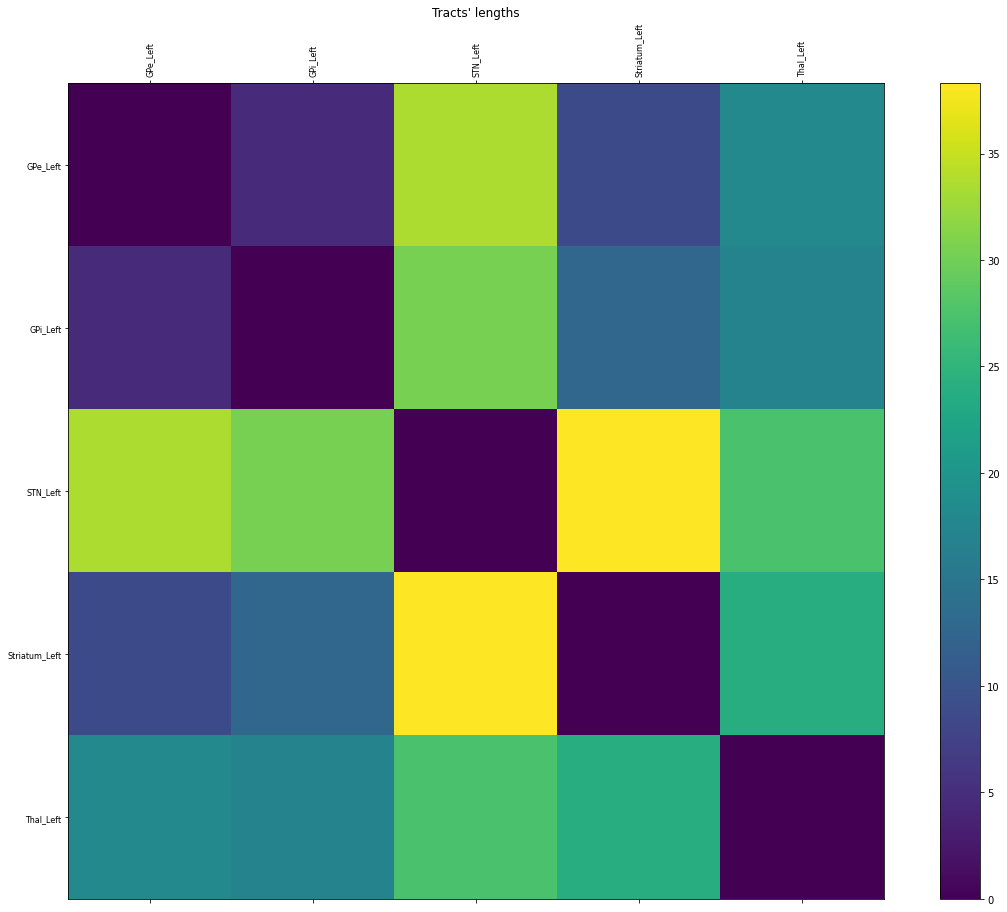

In [4]:
sliceBGnet = slice(0,5)
connTVBleftBG = Connectivity(region_labels=connLeft.region_labels[sliceBGnet], 
                             centres=connLeft.centres[sliceBGnet],
                             weights=connLeft.weights[sliceBGnet][:, sliceBGnet],
                             tract_lengths=connLeft.tract_lengths[sliceBGnet][:, sliceBGnet], 
                            speed=connLeft.speed)
connTVBleftBG.configure()

print("\nLeft BG TVB network:")
plotter.plot_tvb_connectivity(connTVBleftBG);


In [5]:
scaleBGoptTOtvb = np.percentile(BG_opt_matrix_weights, 95) /\
                  np.percentile(connTVBleftBG.weights, 95)
                  
print("Scaling factor of TVB BG network connectome to optimal one = %g" % scaleBGoptTOtvb)


Scaling factor of TVB BG network connectome to optimal one = 0.00205875



Left BG optimized network:


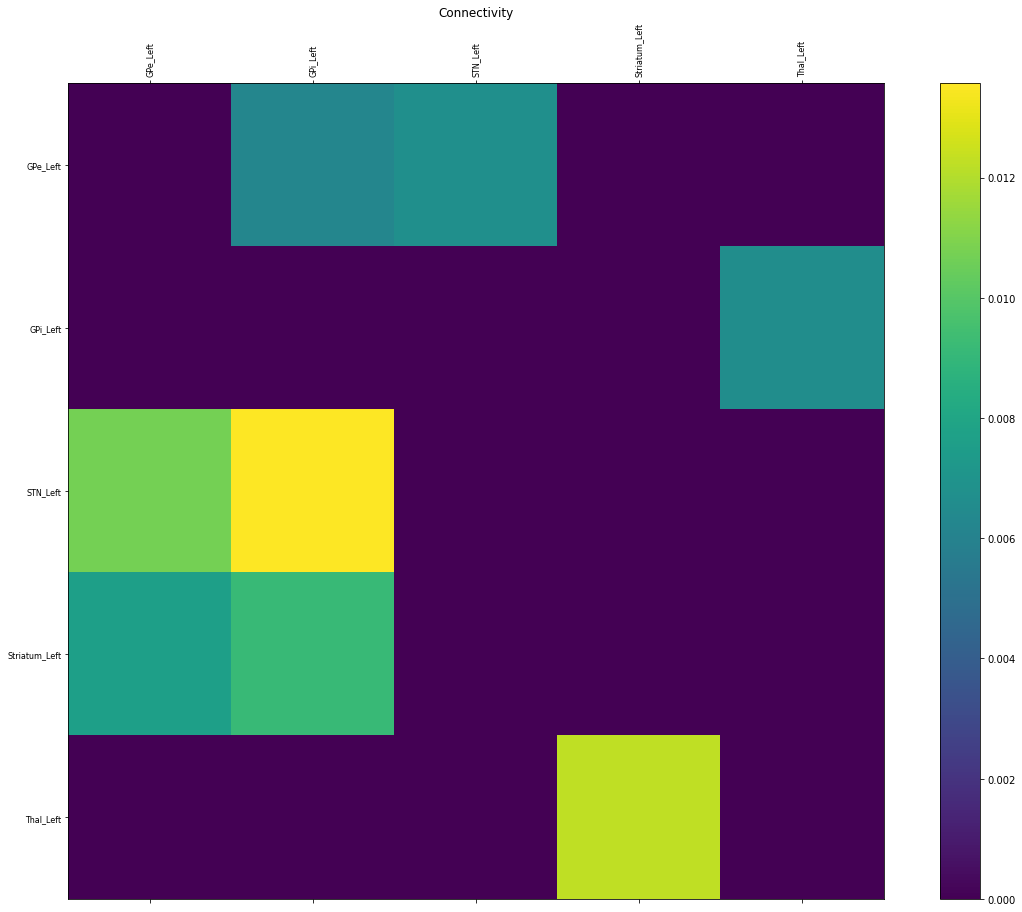

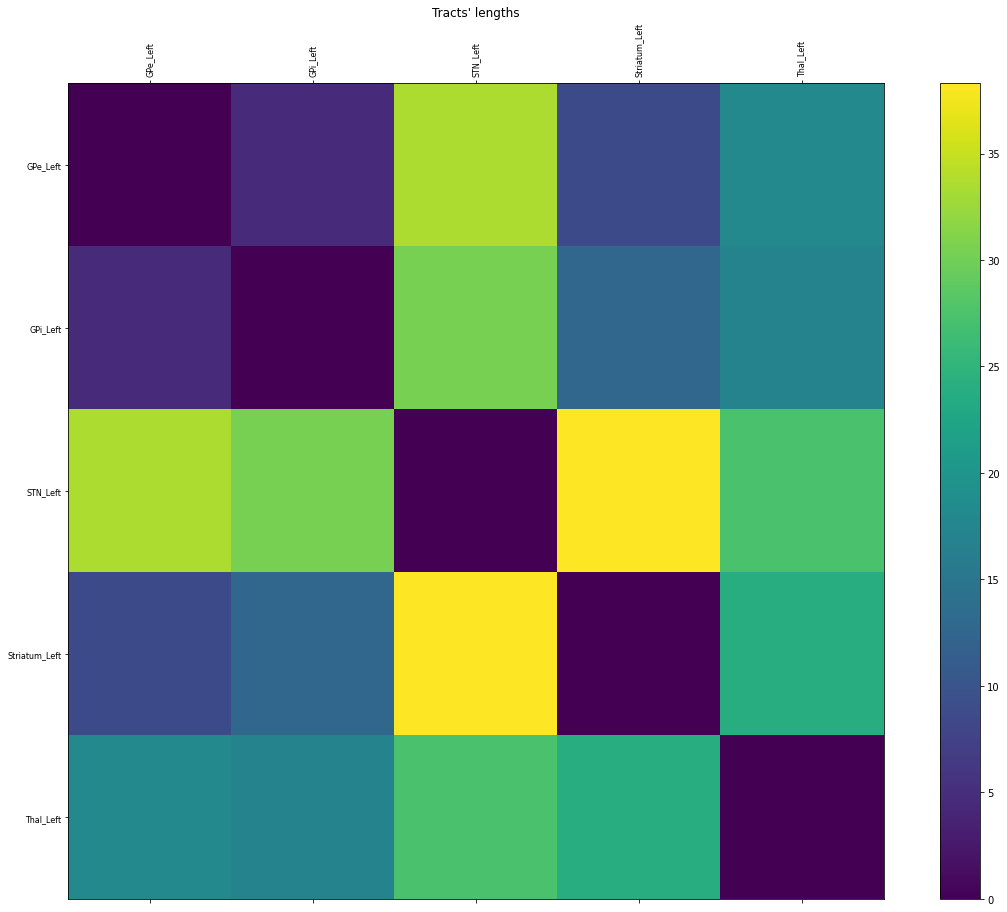

In [6]:
# Construct the final connectivity to use for simulation:
ww = scaleBGoptTOtvb * np.array(connLeft.weights)
ww[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

connectivity = Connectivity(region_labels=connLeft.region_labels, 
                            centres=connLeft.centres,
                            weights=ww, tract_lengths=connLeft.tract_lengths, 
                            speed=connLeft.speed)
connectivity.configure()

# Construct only the optimized BG connectivity only for plotting:
connBGopt = Connectivity(region_labels=connectivity.region_labels[sliceBGnet], 
                         centres=connectivity.centres[sliceBGnet],
                         weights=connectivity.weights[sliceBGnet][:, sliceBGnet],
                         tract_lengths=connectivity.tract_lengths[sliceBGnet][:, sliceBGnet], 
                         speed=connectivity.speed)
connBGopt.configure()

print("\nLeft BG optimized network:")
plotter.plot_tvb_connectivity(connBGopt);



Connectome used for simulations:


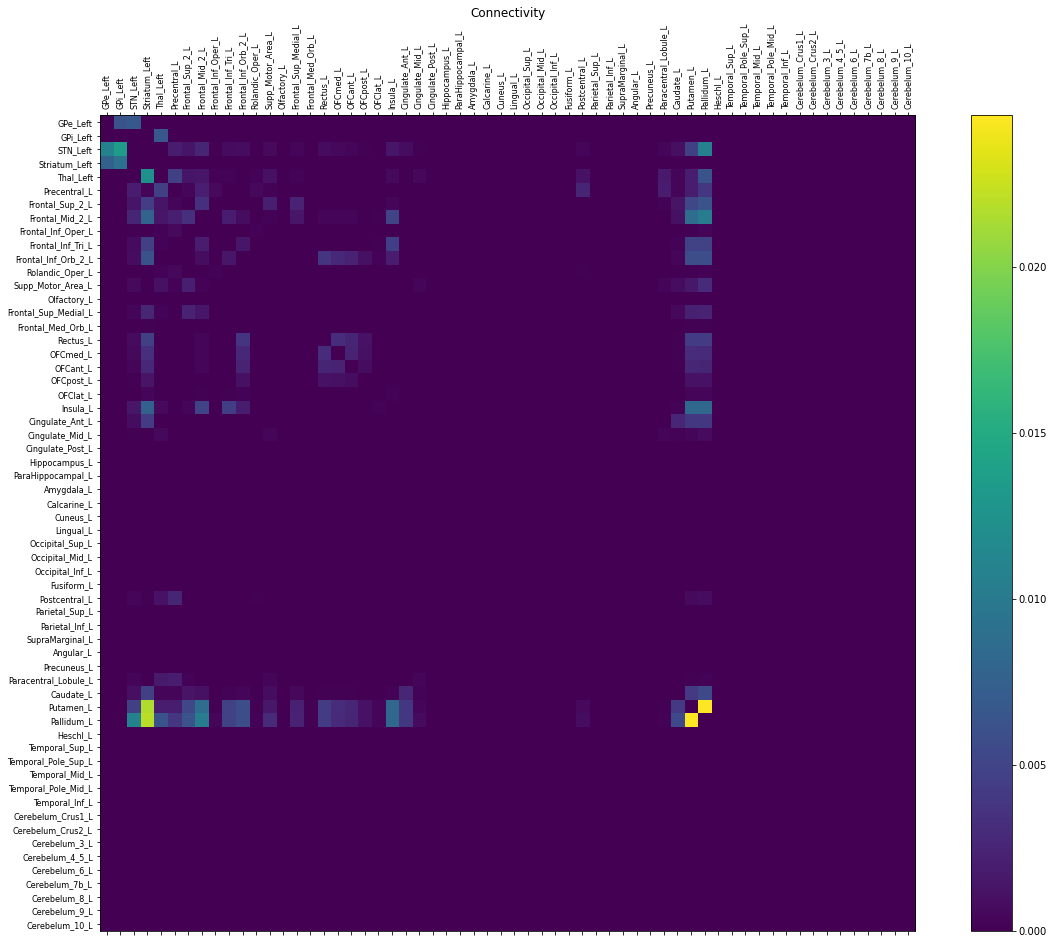

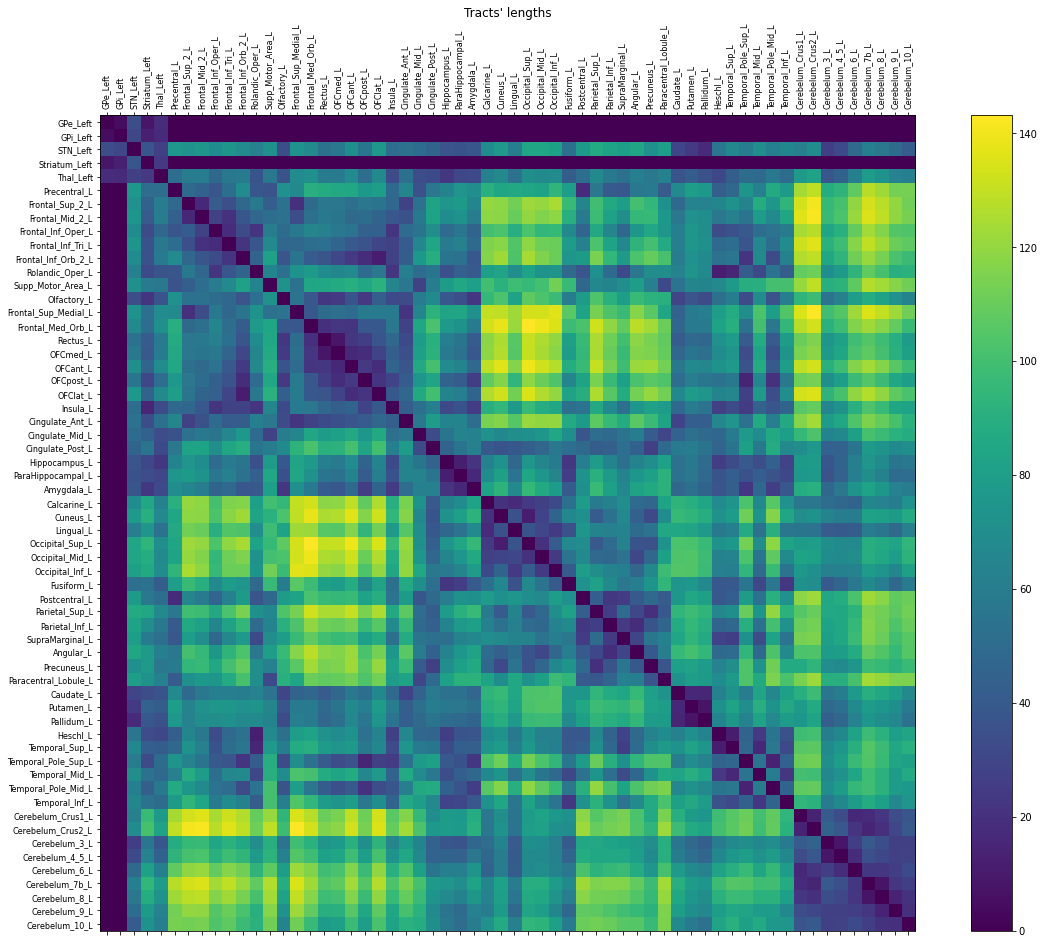

In [7]:
#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-6])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond = np.load(os.path.join(outputs_path, "tvb_init_cond_left_noVermis.npy"))  # 
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations:")
plotter.plot_tvb_connectivity(simulator.connectivity);


## 2. Build and connect the ANNarchy network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [8]:
from tvb_multiscale.tvb_annarchy.annarchy_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder
from tvb_multiscale.tvb_annarchy.annarchy.models import Izhikevich_Hamker

# Select the regions for the fine scale modeling with ANNarchy spiking networks
#including cortex node:
spiking_nodes_ids = [0, 1, 2, 3, 4]  # the indices of fine scale regions modeled with ANNarchy

# Build a ANNarchy network model with the corresponding builder
ann_model_builder = BasalGangliaIzhikevichBuilder(simulator, spiking_nodes_ids, config=config, set_defaults=False)



# Using all default parameters for this example
# ann_model_builder.set_defaults()

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = Izhikevich_Hamker

ann_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

ann_model_builder.params_common = \
    {"E_ampa": 0.0, "E_gaba": -90.0, "v_th": 30.0, "Vr": 0.0, "c": -65.0,
     "C": 1.0, "I": 0.0,
     "tau_syn": 1.0, "tau_ampa": 10.0, "tau_gaba": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

ann_model_builder._paramsI = deepcopy(ann_model_builder.params_common)
ann_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
ann_model_builder._paramsE = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr = deepcopy(ann_model_builder.params_common)
ann_model_builder.paramsStr.update({"v_th": 40.0, "C": 50.0, "Vr": -80.0,
                                    "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                    "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

ann_model_builder.Igpe_nodes_ids = [0]
ann_model_builder.Igpi_nodes_ids = [1]
ann_model_builder.Estn_nodes_ids = [2]
ann_model_builder.Eth_nodes_ids = [4]
ann_model_builder.Istr_nodes_ids = [3]


I_nodes_ids = ann_model_builder.Igpe_nodes_ids + ann_model_builder.Igpi_nodes_ids
E_nodes_ids = ann_model_builder.Estn_nodes_ids + ann_model_builder.Eth_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(ann_model_builder._paramsE)
    if node_id in ann_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I": 3.0})  # dictionary of params for Estn
    elif node_id in ann_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I": 3.5})   # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(ann_model_builder._paramsI)
    if node_id in ann_model_builder.Igpe_nodes_ids:
        paramsI.update({"I": 12.0})
    elif node_id in ann_model_builder.Igpi_nodes_ids:
        paramsI.update({"I": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
ann_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": ann_model_builder.paramsStr, 
     "nodes": ann_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
ann_model_builder.global_coupling_scaling = 1.0 # ann_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# ann_model_builder.global_coupling_scaling *= ann_model_builder.G

synapse_model = "DefaultSpikingSynapse"
conn_spec = {'rule': "all_to_all", "allow_self_connections": True, "force_multiple_weights": False}
conn_spec_fixed_probability = conn_spec.copy()
conn_spec_fixed_probability.update({'rule': "fixed_probability", "probability": 0.1})

def conn_spec_fixed_prob(prob=None):
    output = conn_spec_fixed_probability.copy()
    if prob is not None:
        output["probability"] = prob
    return output

within_node_delay = 1.0
        

# for each connection, we have a different probability
ann_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPe),  # conn_spec
     "weight": np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for population "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiGPi),  # conn_spec
     "weight": np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNdSN),  # conn_spec
     "weight": np.abs(wdSNdSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNiSN),  # conn_spec
     "weight": np.abs(wiSNiSN), "delay": within_node_delay,
     "receptor_type": "gaba", "nodes": ann_model_builder.Istr_nodes_ids}
    ]


# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay
        
class TVBWeightFun(object):
    tvb_weights = ann_model_builder.tvb_weights
    global_coupling_scaling = ann_model_builder.global_coupling_scaling
    
    def __init__(self, scale=ann_model_builder.global_coupling_scaling):
        self.tvb_weights = ann_model_builder.tvb_weights
        self.global_coupling_scaling = ann_model_builder.global_coupling_scaling
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(ann_model_builder.tvb_dt, tvb_delay(source_node, target_node, ann_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
ann_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Istr_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpi_nodes_ids, 
     "target_nodes": ann_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "gaba", 
     "source_nodes": ann_model_builder.Igpe_nodes_ids, 
     "target_nodes": ann_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThdSN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pThiSN),  # conn_spec
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Eth_nodes_ids, 
     "target_nodes": ann_model_builder.Istr_nodes_ids},  # No
     {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec_fixed_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": "ampa", 
     "source_nodes": ann_model_builder.Estn_nodes_ids, 
     "target_nodes": ann_model_builder.Igpi_nodes_ids}
     ]

# Creating  devices to be able to observe ANNarchy activity:

ann_model_builder.output_devices = []

period = 1.0

# Creating  devices to be able to observe ANNarchy activity:
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["SpikeMonitor"])
params["period"] = period
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #                      label <- target population
    params["label"] = pop["label"] + "_spikes"
    connections[params["label"]] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "SpikeMonitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different for every connection to every distinct population
# params for baladron implementation commented out for the moment
# TODO: use baladron neurons
params = deepcopy(ann_model_builder.config.ANNARCHY_OUTPUT_DEVICES_PARAMS_DEF["Monitor"])
params.update({"period": period,  'record_from': ["v", "u", "I_syn", "I_syn_ex", "I_syn_in", "g_ampa", "g_gaba", "g_base"]})
for pop in ann_model_builder.populations:
    connections = OrderedDict({})
    #               label    <- target population
    connections[pop["label"]] = pop["label"]
    params["label"] = pop["label"]
    ann_model_builder.output_devices.append(
        {"model": "Monitor", "params": deepcopy(params),
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    
    
# # Create a spike stimulus input device
# # including cortex node: we do not need any other external stimulation
# ann_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# ann_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# ann_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
ann_model_builder.input_devices = [
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Estn_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[0]["scale"](ann_model_builder.Estn_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineEstn"},
#              "connections": {"BaselineEstn": ["E"]},  # "Estn"
#              "nodes": ann_model_builder.Estn_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpe_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpe_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpe"},
#              "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#              "nodes": ann_model_builder.Igpe_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
#             {"model": "PoissonPopulation",
#              "params": {"rates": ann_model_builder.Igpi_stim["rate"], 
#                         "geometry": int(np.round(ann_model_builder.populations[1]["scale"](ann_model_builder.Igpi_nodes_ids) * 
#                                                  ann_model_builder.population_order)), 
#                         "name": "BaselineIgpi"},
#              "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#              "nodes": ann_model_builder.Igpi_nodes_ids,  # None means apply to all
#              "weights": ann_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": "ampa"},
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


annarchy_network = ann_model_builder.build_spiking_network()


ANNarchy 4.6 (4.6.9.7) on linux (posix). 
2021-02-25 17:29:45,462 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-02-25 17:29:45,462 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Loading an ANNarchy instance...
2021-02-25 17:29:45,466 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-02-25 17:29:45,466 - INFO - tvb_multiscale.tvb_annarchy.annarchy_models.builders.base - Cleaning ANNarchy compilation directory, if any...
2021-02-25 17:29:46,582 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-02-25 17:29:46,582 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model SpikeMonitor for E_spikes created!
2021-02-25 17:29:46,594 - INFO - tvb_multiscale.co

In [9]:
populations_sizes = []
print("Population sizes: ")
for pop in ann_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    

Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


## 3. Build the TVB-ANNarchy interface

In [10]:
from tvb_multiscale.tvb_annarchy.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-ANNarchy interface with all the appropriate connections between the
# TVB and ANNarchy modelled regions
tvb_annarchy_builder = \
    RedWWexcIOBuilder(simulator, annarchy_network, spiking_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_annarchy_mode = "rate"
annarchy_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> ANNarchy


# --------For spike transmission from TVB to ANNarchy devices acting as TVB proxy nodes with TVB delays:--------

# tvb_annarchy_builder.G = tvb_annarchy_builder.tvb_simulator.model.G[0].item()
# tvb_annarchy_builder.global_coupling_scaling = tvb_annarchy_builder.tvb_simulator.coupling.a[0].item() * tvb_annarchy_builder.G
tvb_annarchy_builder.global_coupling_scaling = 1.0

tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_annarchy_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_annarchy_builder.tvb_delays))

tvb_annarchy_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_annarchy_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes in zip([["IdSN", "IiSN"],                  
                                      "E"],
                                      [ann_model_builder.Istr_nodes_ids, 
                                       E_nodes_ids]):  # ann_model_builder.Estn_nodes_ids
        tvb_annarchy_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "PoissonPopulation", "params": {"geometry": 200},
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 50.0,
        # Applied outside ANNarchy for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, annarchy_node_id=None)-----------
             "weights": TVBWeightFun(scale=tvb_annarchy_builder.global_coupling_scaling),
             "delays": lambda tvb_node_id, annarchy_node_id: tvb_delay_fun(tvb_node_id, annarchy_node_id),
             "receptor_type": "ampa",
        # --------------------------------------------------------------------------------------------------------------
        #             TVB sv -> ANNarchy population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if annarchy_to_tvb:
    tvb_annarchy_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- ANNarchy:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, ann_model_builder.Istr_nodes_ids]):
        #            TVB <- ANNarchy
        tvb_annarchy_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "SpikeMonitor", "params": {},
        # ------------------Properties potentially set as function handles with args (annarchy_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------                 #            TVB <- ANNarchy
        #                    TVB <- ANNarchy
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    
tvb_annarchy_builder.w_tvb_to_spike_rate = 1.0
# We return from a ANNarchy SpikeMonitor the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_annarchy_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_annarchy_model = tvb_annarchy_builder.build_interface(tvb_to_annarchy_mode=tvb_to_annarchy_mode, annarchy_to_tvb=annarchy_to_tvb)


2021-02-25 17:29:48,107 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-02-25 17:29:48,107 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-02-25 17:29:48,110 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-02-25 17:29:48,110 - INFO - tvb_multiscale.tvb_annarchy.interfaces.models - <class 'tvb_multiscale.tvb_annarchy.interfaces.models.RedWWexcIO'> created!
2021-02-25 17:29:48,119 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model PoissonPopulation for R created!
2021-02-25 17:29:48,119 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model PoissonPopulation for R created!
2021-02-25 17:29:48,594 - 

## 3. Configure simulator, simulate, gather results

In [11]:
# -----------------------------------4. Compile network ---------------------------------------------------------
# Compile the ANNarchy network...
tic_compile = time.time()
annarchy_network.configure()
print("Compiled! in %f min" % ((time.time() - tic_compile) / 60))
print(annarchy_network.print_str(connectivity=True))
print(tvb_annarchy_model.print_str(detailed_output=True, connectivity=False))


Compiling... 
OK 
Compiled! in 4.465863 min

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
ANNarchyNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPi_Left', 'STN_Left', 'Striatum_Left', 'Thal_Left']
Regions' nodes:


----------------------------------------------------------------------------------------------------
ANNarchyRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

ANNarchyPopulation - Label: I 
model: Spiking neuron
200 neurons in population with index: 0
parameters: {'a': array([0.005]), 'b': array([0.585]), 'c': array([-

In [12]:
 # -----------------------------------5. Simulate and gather results-------------------------------------------------
simulation_length = 110.0
transient = 10.0 # simulation_length/11
# ...and simulate!
t_start = time.time()
simulator.configure(tvb_annarchy_model)

if simulation_mode == "rs":
    simulation_length1 = simulation_length
else:
    simulation_length1 = 35.0
    
results = simulator.run(simulation_length=simulation_length1, # 35.0 with stimulus application
                        configure_spiking_simulator=False)    # because compilation has already be done

if simulation_mode != "rs":
    # for stimulus application:
    Istim = -200.0
    annarchy_network.brain_regions["GPi_Left"]["I"].Set(
        {"I": Istim + annarchy_network.brain_regions["GPi_Left"]["I"].Get("I")["I"]})
    results2 = simulator.run(simulation_length=50.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    annarchy_network.brain_regions["GPi_Left"]["I"].Set(
        {"I": annarchy_network.brain_regions["GPi_Left"]["I"].Get("I")["I"] - Istim})
    results3 = simulator.run(simulation_length=25.0, 
                             configure_spiking_simulator=False)  # because compilation has already be done
    results[0] = list(results[0])
    results[0][0] = np.concatenate([results[0][0], results2[0][0], results3[0][0]], axis=0)
    results[0][1] = np.concatenate([results[0][1], results2[0][1], results3[0][1]], axis=0)

print("\nSimulated in %f secs!" % (time.time() - t_start))

Simulating 0.0001 seconds of the network took 0.0009679794311523438 seconds. 
Simulating 0.0001 seconds of the network took 0.0007746219635009766 seconds. 
Simulating 0.0001 seconds of the network took 0.0005886554718017578 seconds. 
Simulating 0.0001 seconds of the network took 0.0005311965942382812 seconds. 
Simulating 0.0001 seconds of the network took 0.0006153583526611328 seconds. 
Simulating 0.0001 seconds of the network took 0.0008156299591064453 seconds. 
Simulating 0.0001 seconds of the network took 0.00072479248046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0006239414215087891 seconds. 
Simulating 0.0001 seconds of the network took 0.0005297660827636719 seconds. 
Simulating 0.0001 seconds of the network took 0.0005395412445068359 seconds. 
Simulating 0.0001 seconds of the network took 0.0005803108215332031 seconds. 
Simulating 0.0001 seconds of the network took 0.0005991458892822266 seconds. 
Simulating 0.0001 seconds of the network took 0.000522375106811523

Simulating 0.0001 seconds of the network took 0.0011889934539794922 seconds. 
...10.0% done in 3.1 sec
Simulating 0.0001 seconds of the network took 0.0010001659393310547 seconds. 
Simulating 0.0001 seconds of the network took 0.0009267330169677734 seconds. 
Simulating 0.0001 seconds of the network took 0.0007729530334472656 seconds. 
Simulating 0.0001 seconds of the network took 0.0009734630584716797 seconds. 
Simulating 0.0001 seconds of the network took 0.0008380413055419922 seconds. 
Simulating 0.0001 seconds of the network took 0.0007803440093994141 seconds. 
Simulating 0.0001 seconds of the network took 0.00093841552734375 seconds. 
Simulating 0.0001 seconds of the network took 0.0008726119995117188 seconds. 
Simulating 0.0001 seconds of the network took 0.0009150505065917969 seconds. 
Simulating 0.0001 seconds of the network took 0.0010423660278320312 seconds. 
Simulating 0.0001 seconds of the network took 0.00118255615234375 seconds. 
Simulating 0.0001 seconds of the network to

Simulating 0.0001 seconds of the network took 0.0014717578887939453 seconds. 
Simulating 0.0001 seconds of the network took 0.0011954307556152344 seconds. 
Simulating 0.0001 seconds of the network took 0.0013966560363769531 seconds. 
Simulating 0.0001 seconds of the network took 0.001344442367553711 seconds. 
Simulating 0.0001 seconds of the network took 0.0016295909881591797 seconds. 
Simulating 0.0001 seconds of the network took 0.001295328140258789 seconds. 
Simulating 0.0001 seconds of the network took 0.0012767314910888672 seconds. 
Simulating 0.0001 seconds of the network took 0.0011959075927734375 seconds. 
Simulating 0.0001 seconds of the network took 0.0014505386352539062 seconds. 
Simulating 0.0001 seconds of the network took 0.0013055801391601562 seconds. 
Simulating 0.0001 seconds of the network took 0.0011119842529296875 seconds. 
Simulating 0.0001 seconds of the network took 0.0012993812561035156 seconds. 
Simulating 0.0001 seconds of the network took 0.001383304595947265

Simulating 0.0001 seconds of the network took 0.0016999244689941406 seconds. 
Simulating 0.0001 seconds of the network took 0.0013115406036376953 seconds. 
Simulating 0.0001 seconds of the network took 0.0010819435119628906 seconds. 
Simulating 0.0001 seconds of the network took 0.0011172294616699219 seconds. 
Simulating 0.0001 seconds of the network took 0.0013332366943359375 seconds. 
Simulating 0.0001 seconds of the network took 0.0011637210845947266 seconds. 
Simulating 0.0001 seconds of the network took 0.0011518001556396484 seconds. 
Simulating 0.0001 seconds of the network took 0.0012569427490234375 seconds. 
Simulating 0.0001 seconds of the network took 0.0011203289031982422 seconds. 
Simulating 0.0001 seconds of the network took 0.0013797283172607422 seconds. 
Simulating 0.0001 seconds of the network took 0.0015246868133544922 seconds. 
Simulating 0.0001 seconds of the network took 0.0012640953063964844 seconds. 
Simulating 0.0001 seconds of the network took 0.0012547969818115

Simulating 0.0001 seconds of the network took 0.0011751651763916016 seconds. 
Simulating 0.0001 seconds of the network took 0.0012485980987548828 seconds. 
Simulating 0.0001 seconds of the network took 0.001102447509765625 seconds. 
Simulating 0.0001 seconds of the network took 0.0010945796966552734 seconds. 
...40.0% done in 12.2 sec
Simulating 0.0001 seconds of the network took 0.0011959075927734375 seconds. 
Simulating 0.0001 seconds of the network took 0.0010602474212646484 seconds. 
Simulating 0.0001 seconds of the network took 0.0010733604431152344 seconds. 
Simulating 0.0001 seconds of the network took 0.0010972023010253906 seconds. 
Simulating 0.0001 seconds of the network took 0.0010285377502441406 seconds. 
Simulating 0.0001 seconds of the network took 0.0009980201721191406 seconds. 
Simulating 0.0001 seconds of the network took 0.0013186931610107422 seconds. 
Simulating 0.0001 seconds of the network took 0.0019719600677490234 seconds. 
Simulating 0.0001 seconds of the networ

Simulating 0.0001 seconds of the network took 0.0010628700256347656 seconds. 
Simulating 0.0001 seconds of the network took 0.0013232231140136719 seconds. 
Simulating 0.0001 seconds of the network took 0.0011377334594726562 seconds. 
Simulating 0.0001 seconds of the network took 0.0012059211730957031 seconds. 
Simulating 0.0001 seconds of the network took 0.0010671615600585938 seconds. 
Simulating 0.0001 seconds of the network took 0.0010290145874023438 seconds. 
Simulating 0.0001 seconds of the network took 0.0012772083282470703 seconds. 
Simulating 0.0001 seconds of the network took 0.0013773441314697266 seconds. 
Simulating 0.0001 seconds of the network took 0.0010769367218017578 seconds. 
...50.0% done in 15.0 sec
Simulating 0.0001 seconds of the network took 0.0011730194091796875 seconds. 
Simulating 0.0001 seconds of the network took 0.0011675357818603516 seconds. 
Simulating 0.0001 seconds of the network took 0.0010631084442138672 seconds. 
Simulating 0.0001 seconds of the netwo

Simulating 0.0001 seconds of the network took 0.001401662826538086 seconds. 
Simulating 0.0001 seconds of the network took 0.0011966228485107422 seconds. 
Simulating 0.0001 seconds of the network took 0.0011093616485595703 seconds. 
Simulating 0.0001 seconds of the network took 0.0010526180267333984 seconds. 
Simulating 0.0001 seconds of the network took 0.0010223388671875 seconds. 
Simulating 0.0001 seconds of the network took 0.001049041748046875 seconds. 
Simulating 0.0001 seconds of the network took 0.001142263412475586 seconds. 
Simulating 0.0001 seconds of the network took 0.0009691715240478516 seconds. 
Simulating 0.0001 seconds of the network took 0.0011584758758544922 seconds. 
Simulating 0.0001 seconds of the network took 0.0011305809020996094 seconds. 
Simulating 0.0001 seconds of the network took 0.0012984275817871094 seconds. 
...60.0% done in 17.8 sec
Simulating 0.0001 seconds of the network took 0.0010263919830322266 seconds. 
Simulating 0.0001 seconds of the network too

Simulating 0.0001 seconds of the network took 0.0010814666748046875 seconds. 
Simulating 0.0001 seconds of the network took 0.0010619163513183594 seconds. 
Simulating 0.0001 seconds of the network took 0.0010738372802734375 seconds. 
Simulating 0.0001 seconds of the network took 0.0009932518005371094 seconds. 
Simulating 0.0001 seconds of the network took 0.001007080078125 seconds. 
Simulating 0.0001 seconds of the network took 0.0009467601776123047 seconds. 
Simulating 0.0001 seconds of the network took 0.0009503364562988281 seconds. 
Simulating 0.0001 seconds of the network took 0.0012936592102050781 seconds. 
Simulating 0.0001 seconds of the network took 0.0010747909545898438 seconds. 
Simulating 0.0001 seconds of the network took 0.0013012886047363281 seconds. 
Simulating 0.0001 seconds of the network took 0.0011785030364990234 seconds. 
Simulating 0.0001 seconds of the network took 0.0009260177612304688 seconds. 
...70.0% done in 20.6 sec
Simulating 0.0001 seconds of the network t

Simulating 0.0001 seconds of the network took 0.0010404586791992188 seconds. 
Simulating 0.0001 seconds of the network took 0.001140594482421875 seconds. 
Simulating 0.0001 seconds of the network took 0.0011420249938964844 seconds. 
Simulating 0.0001 seconds of the network took 0.0010673999786376953 seconds. 
Simulating 0.0001 seconds of the network took 0.0010006427764892578 seconds. 
Simulating 0.0001 seconds of the network took 0.0009493827819824219 seconds. 
Simulating 0.0001 seconds of the network took 0.001003265380859375 seconds. 
Simulating 0.0001 seconds of the network took 0.0009548664093017578 seconds. 
Simulating 0.0001 seconds of the network took 0.0009474754333496094 seconds. 
Simulating 0.0001 seconds of the network took 0.0011324882507324219 seconds. 
Simulating 0.0001 seconds of the network took 0.0009891986846923828 seconds. 
Simulating 0.0001 seconds of the network took 0.0009682178497314453 seconds. 
...80.0% done in 23.4 sec
Simulating 0.0001 seconds of the network

Simulating 0.0001 seconds of the network took 0.0010790824890136719 seconds. 
Simulating 0.0001 seconds of the network took 0.0010881423950195312 seconds. 
Simulating 0.0001 seconds of the network took 0.0009453296661376953 seconds. 
Simulating 0.0001 seconds of the network took 0.0011525154113769531 seconds. 
Simulating 0.0001 seconds of the network took 0.0010755062103271484 seconds. 
Simulating 0.0001 seconds of the network took 0.0010516643524169922 seconds. 
Simulating 0.0001 seconds of the network took 0.0010342597961425781 seconds. 
Simulating 0.0001 seconds of the network took 0.0010249614715576172 seconds. 
Simulating 0.0001 seconds of the network took 0.0009527206420898438 seconds. 
Simulating 0.0001 seconds of the network took 0.001069784164428711 seconds. 
Simulating 0.0001 seconds of the network took 0.0010142326354980469 seconds. 
Simulating 0.0001 seconds of the network took 0.0009701251983642578 seconds. 
Simulating 0.0001 seconds of the network took 0.00083351135253906

Simulating 0.0001 seconds of the network took 0.0010025501251220703 seconds. 
Simulating 0.0001 seconds of the network took 0.0010221004486083984 seconds. 
Simulating 0.0001 seconds of the network took 0.0011837482452392578 seconds. 
Simulating 0.0001 seconds of the network took 0.0010445117950439453 seconds. 
Simulating 0.0001 seconds of the network took 0.0010666847229003906 seconds. 
Simulating 0.0001 seconds of the network took 0.0010571479797363281 seconds. 
Simulating 0.0001 seconds of the network took 0.0008893013000488281 seconds. 
Simulating 0.0001 seconds of the network took 0.0008940696716308594 seconds. 
Simulating 0.0001 seconds of the network took 0.0010159015655517578 seconds. 
Simulating 0.0001 seconds of the network took 0.0009868144989013672 seconds. 
Simulating 0.0001 seconds of the network took 0.000986337661743164 seconds. 
Simulating 0.0001 seconds of the network took 0.0009603500366210938 seconds. 
Simulating 0.0001 seconds of the network took 0.00105047225952148

## 4. Plot results and write them to HDF5 files

In [13]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in ann_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * ann_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [14]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0] - results[0][0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,1100
Region Mapping,None
Region Mapping Volume,None
Sample period,0.1
Source Connectivity,Connectivity gid: 9a6bce28-5270-44a8-82c3-0a0a69fc4020
Time units,ms
Time-series name,Region Time Series
Time-series type,TimeSeriesRegion
"[min, median, max]","[0, 0.40712, 1000]"


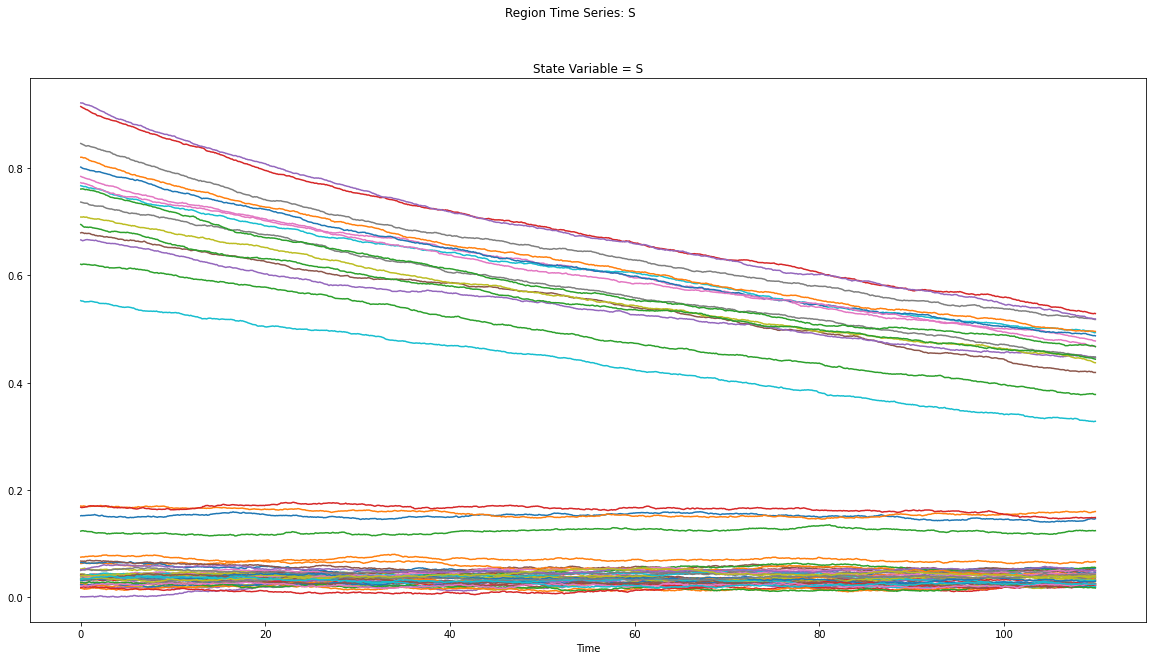

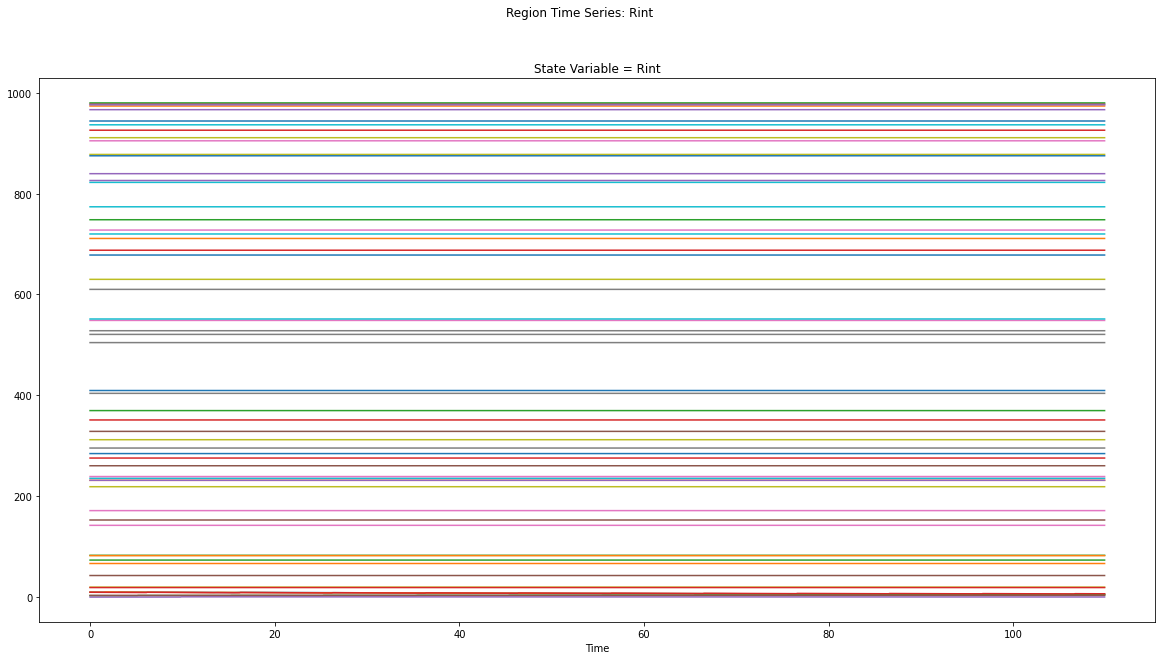

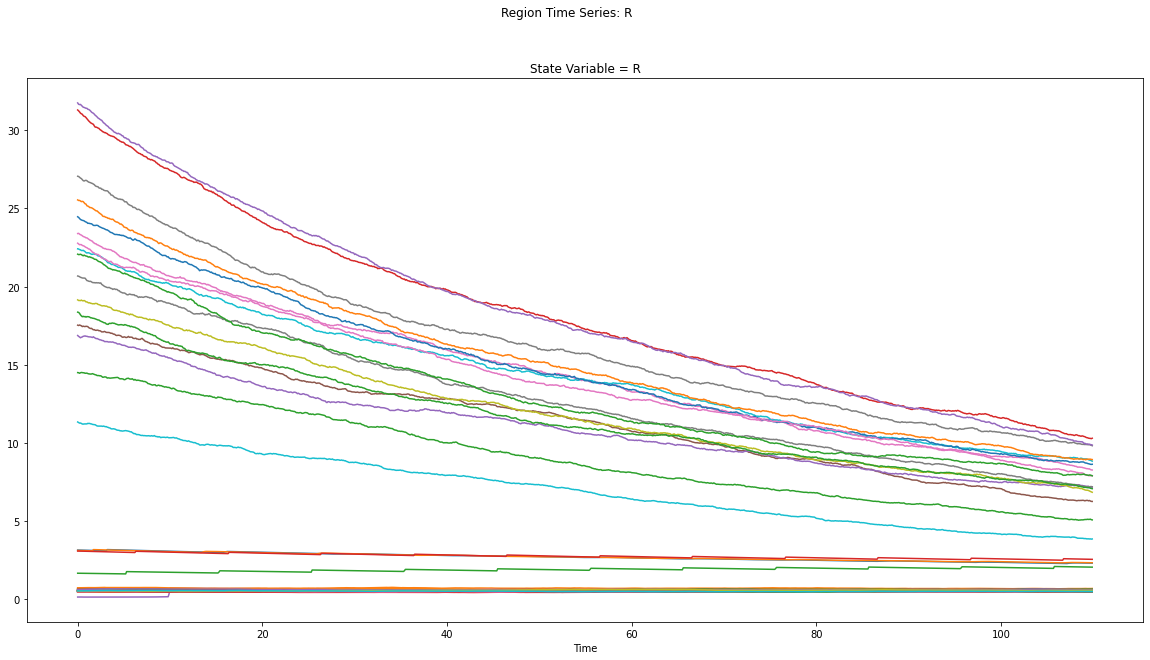

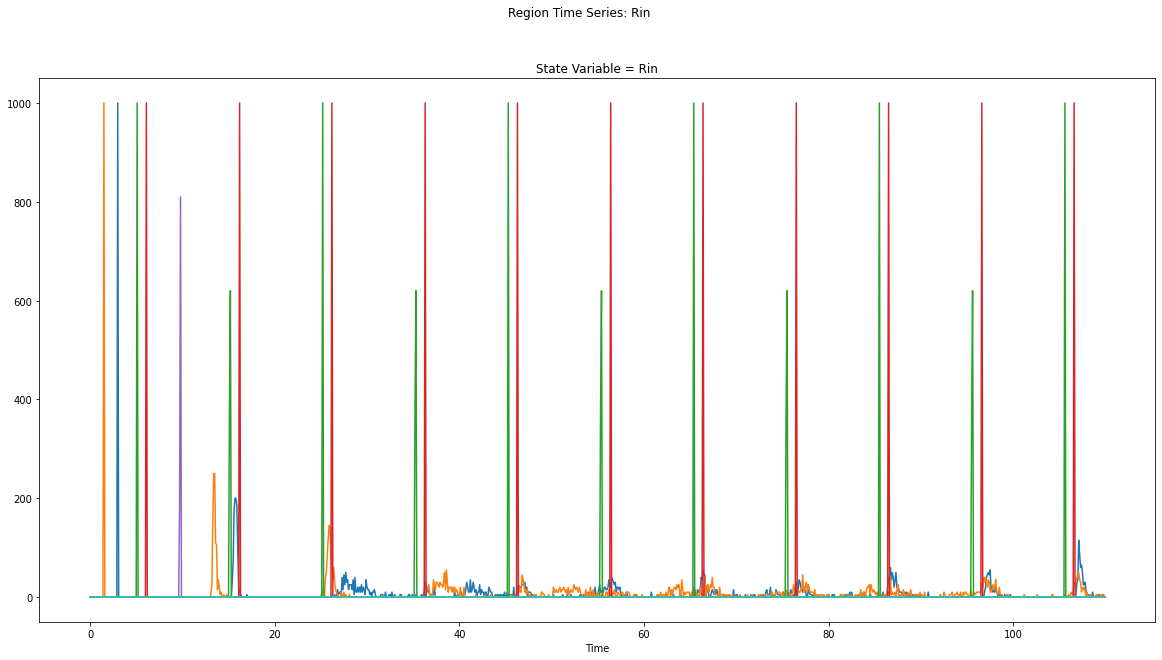

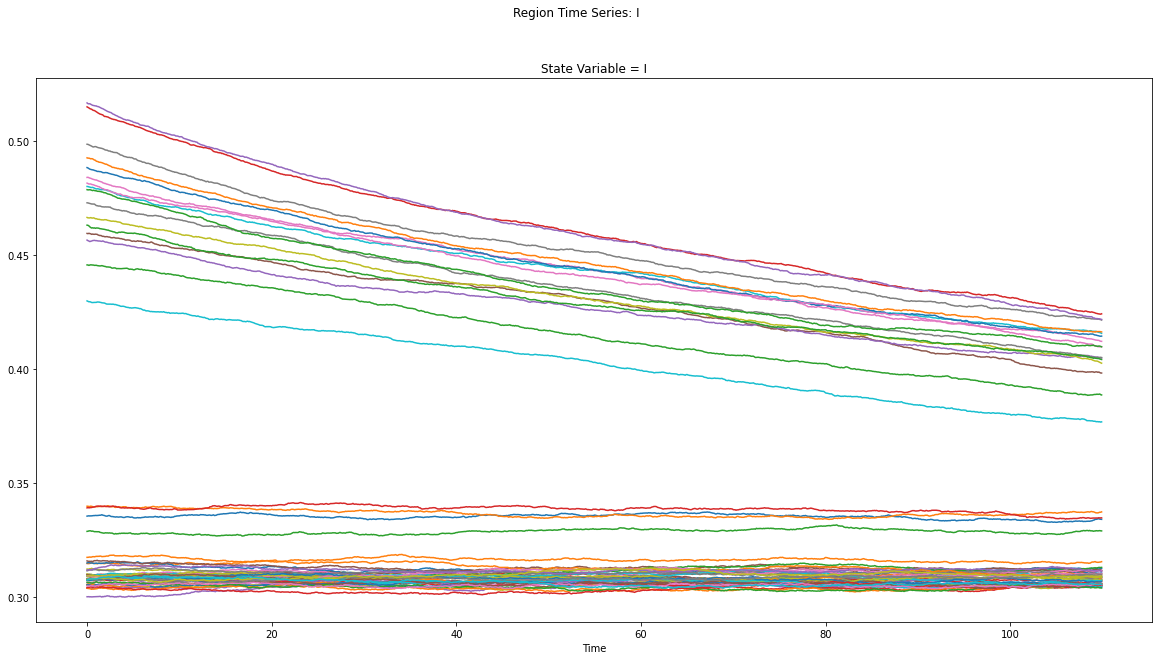

In [15]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [16]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

2021-02-25 17:34:50,508 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:34:50,523 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:34:51,047 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:34:51,427 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:34:51,810 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:34:52,290 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


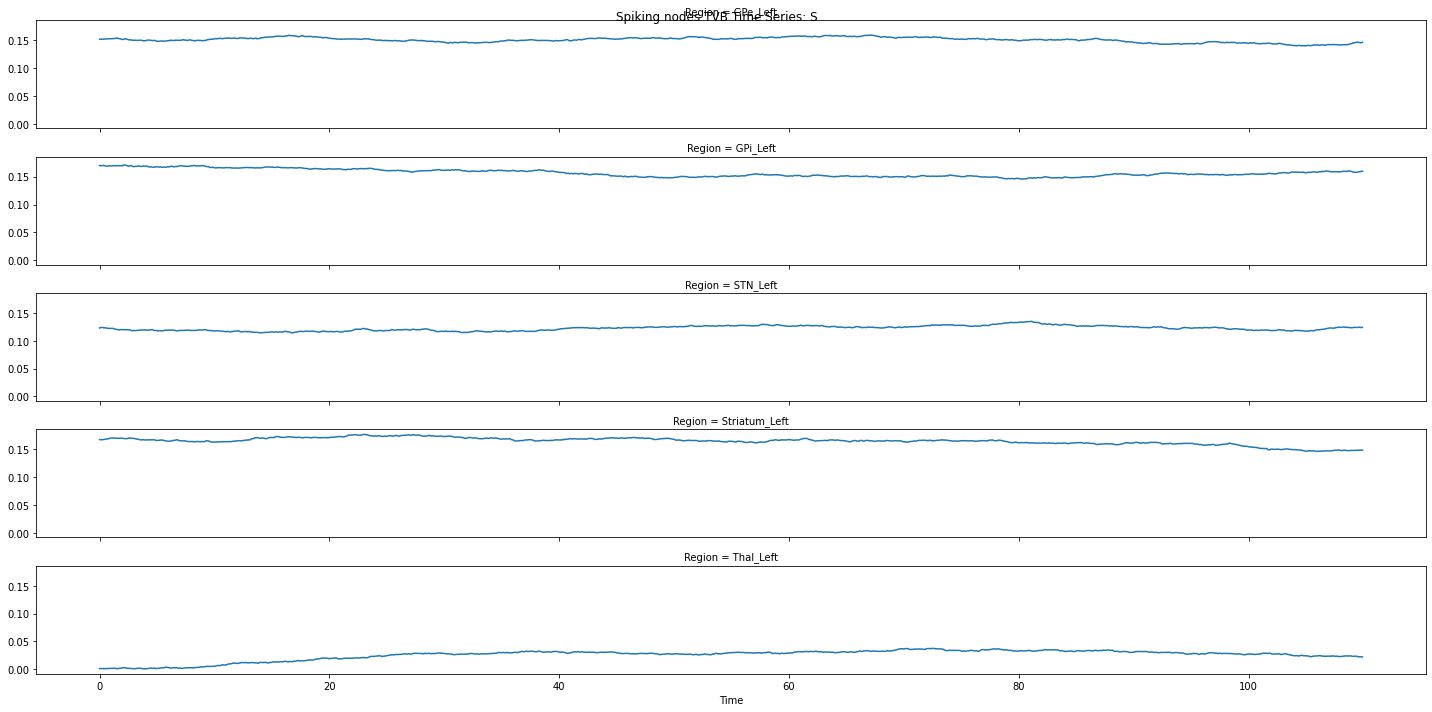

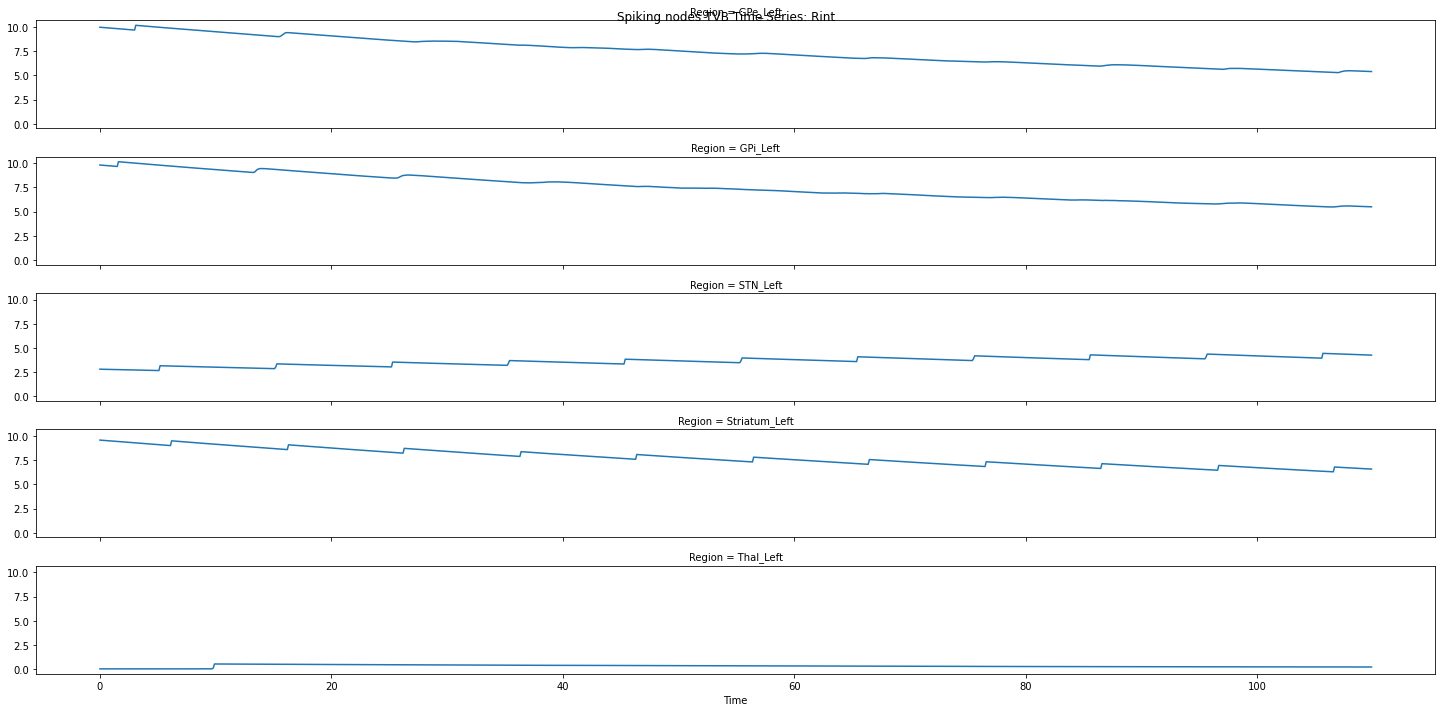

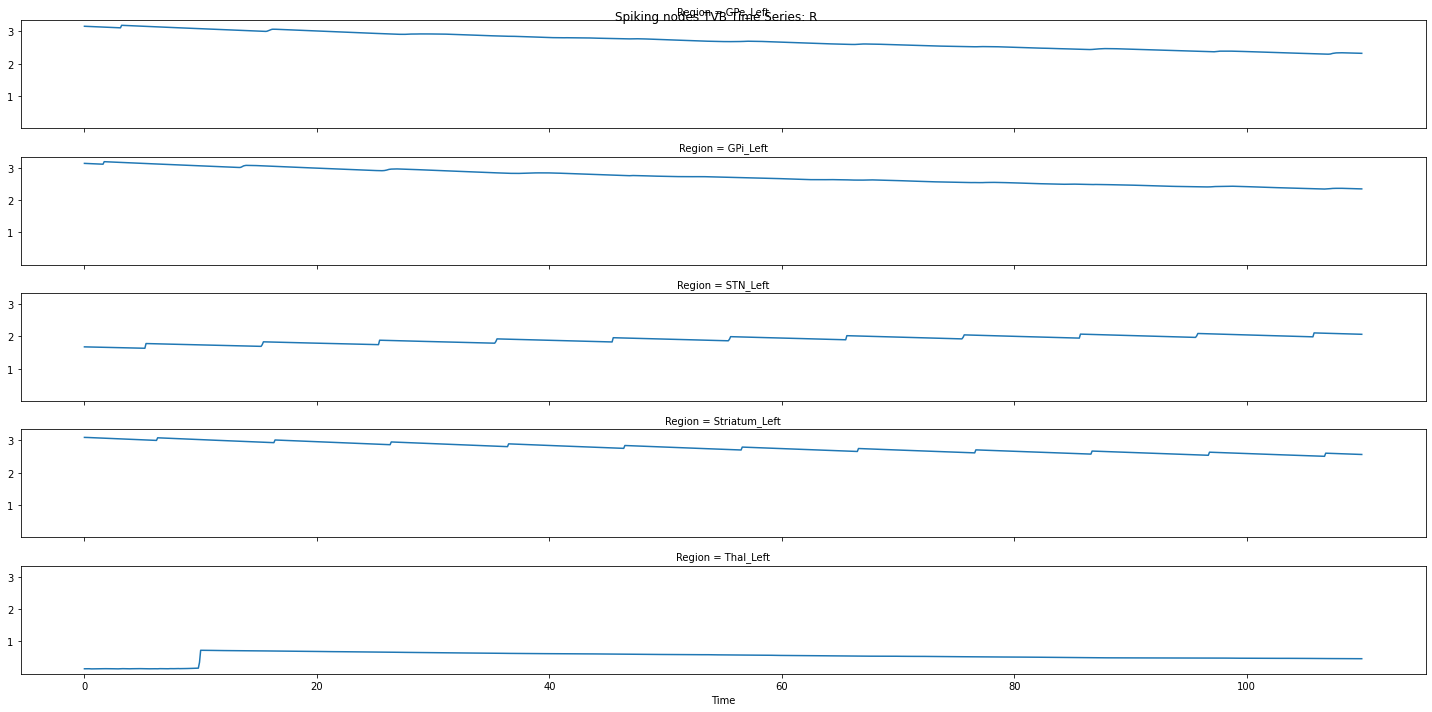

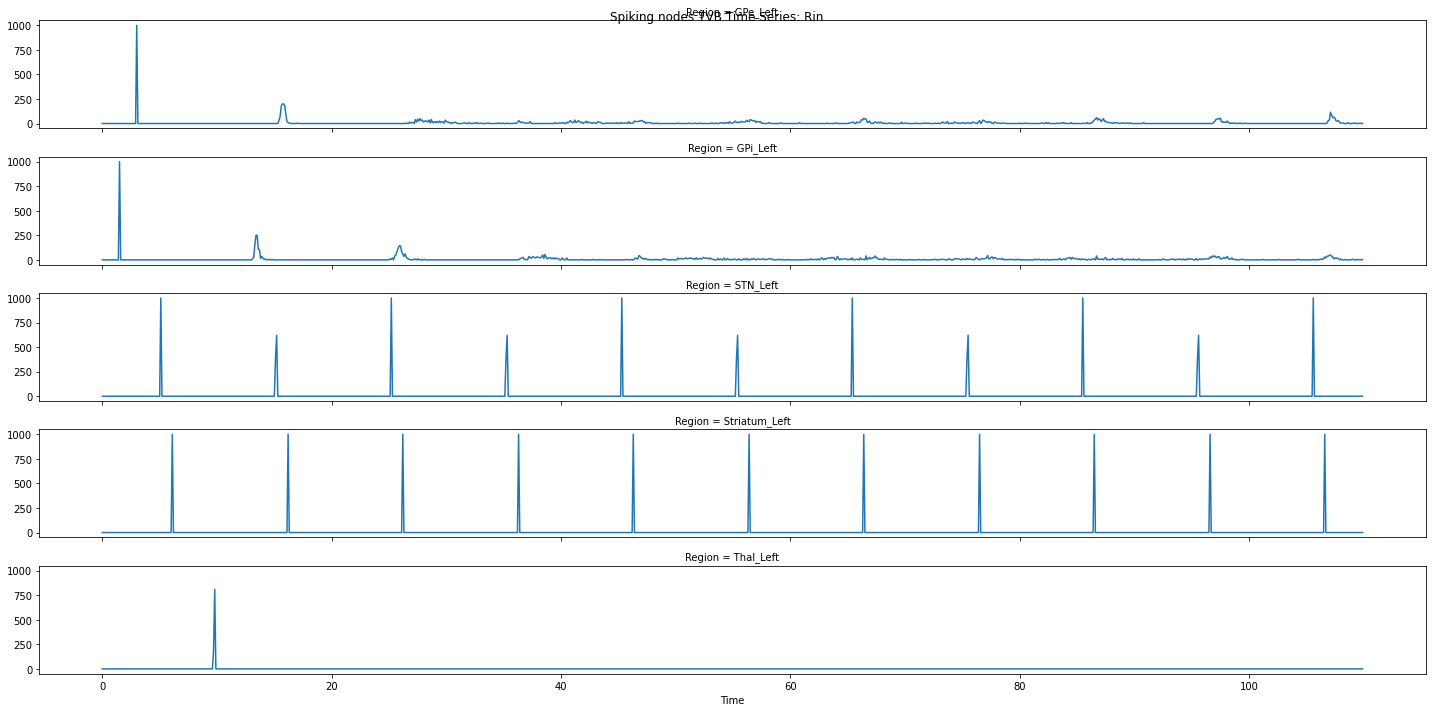

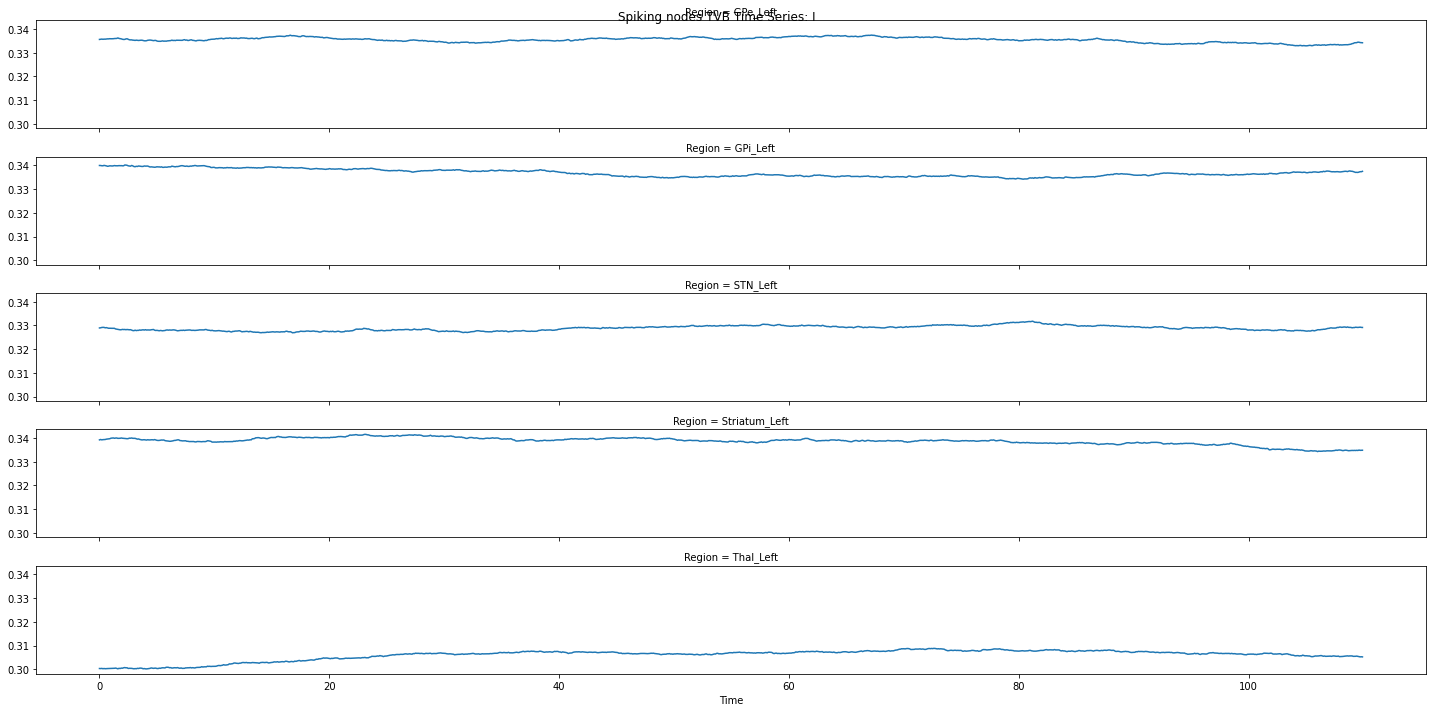

In [17]:
# Focus on the nodes modelled in ANNarchy: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_ann = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_ann.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_ann.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [18]:
# # Focus on the nodes modelled in ANNarchy: raster plot
# if source_ts_ann.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_ann.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_ann.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [19]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data, 
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [20]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=annarchy_network,
                           start_time=period, end_time=simulation_length, 
                           period=period, transient=transient,
                           time_series_output_type="TVB", return_data=True,
                           # elephant_mean_firing_rate=False,
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [21]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:848: UserWarning: Binning discarded 200 last spike(s) of the input spiketrain
  "input spiketrain".format(n_discarded))
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/spike_train_correlation.py:529: UserWarning: Detected empty spike trains (rows) in the binned_spiketrain.
  'Detected empty spike trains (rows) in the binned_spiketrain.')
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/spike_train_correlation.py:536: RuntimeWarning: invalid value encountered in true_divide
  res /= (stdx.T * stdx)


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 5)>
array([[         nan,          nan, 101.01009897,          nan,
          0.        ],
       [ 61.86868562,  68.383837  ,          nan,          nan,
                 nan],
       [         nan,          nan,          nan, 101.01009897,
                 nan],
       [         nan,          nan,          nan, 101.01009897,
                 nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPi_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 5, Region_j: 5)>
array([[[[   nan,    nan,    nan,    nan,    nan],
         [   nan,    nan,    nan,    nan,    nan],
         [   nan,    nan,  1.   ,    nan,    nan],
         [   nan,    nan,    nan,    nan,    nan],
         [   nan,    nan,    nan,    nan,    nan]],

        [[   nan,    nan,    nan,   

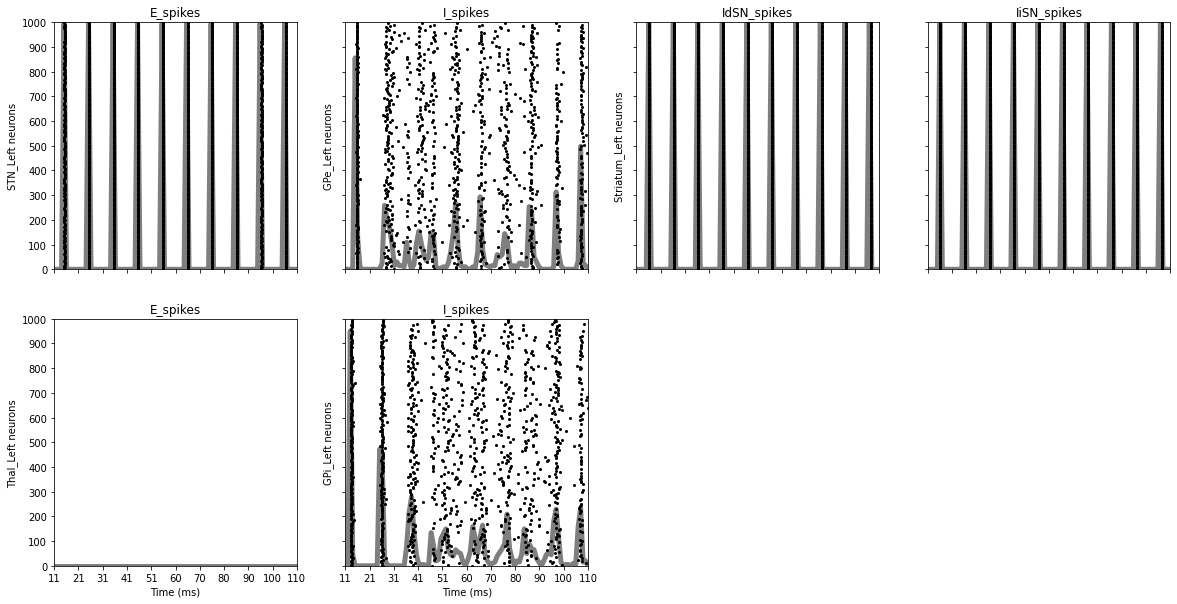

<Figure size 432x288 with 0 Axes>

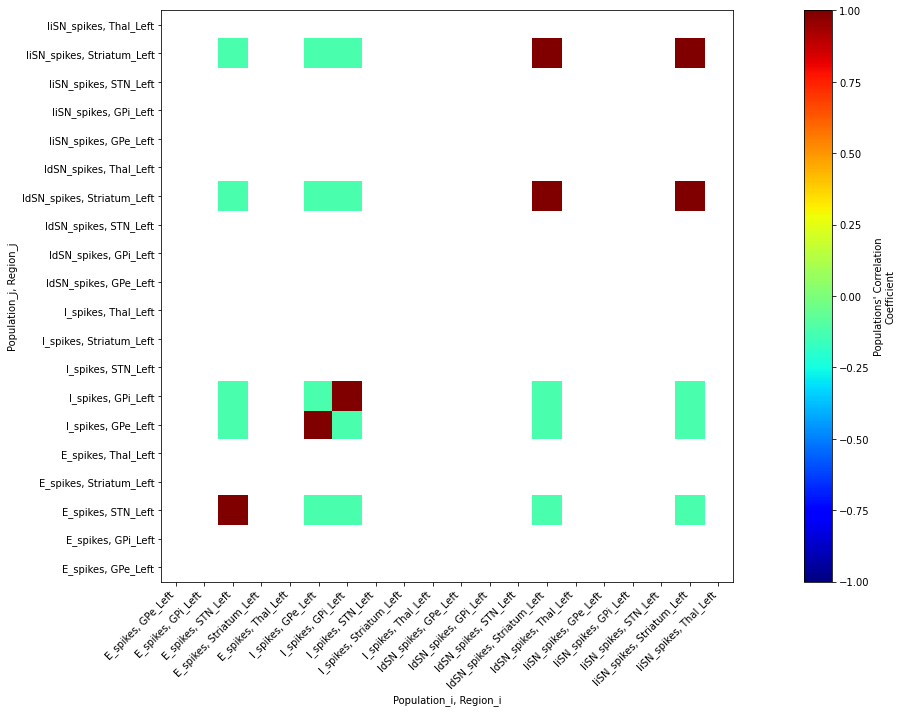

In [22]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"],
                                  figsize=FIGSIZE) #  
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [23]:
print("Mean spike rates:")
for pop in spikes_res["mean_rate"].coords["Population"]:
    for reg in spikes_res["mean_rate"].coords["Region"]:
        if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
            print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                   spikes_res["mean_rate"].loc[pop, reg].values.item()))

Mean spike rates:
E - STN_Left: 101.01
E - Thal_Left: 0
I - GPe_Left: 61.8687
I - GPi_Left: 68.3838
IdSN - Striatum_Left: 101.01
IiSN - Striatum_Left: 101.01


In [24]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2021-02-25 17:34:57,747 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/rs/res/Spikes.h5
2021-02-25 17:34:57,747 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_annarchy/notebooks/outputs/outputs_Izhikevich_annarchy/TVBcortex/rs/res/Spikes.h5
2021-02-25 17:34:57,770 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-02-25 17:34:57,770 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-02-25 17:34:57,774 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-02-25 17:34:57,774 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy

2021-02-25 17:34:57,848 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-02-25 17:34:57,848 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2021-02-25 17:34:57,851 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-02-25 17:34:57,851 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2021-02-25 17:34:57,855 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPi_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 1.55 13.65 26.25 ... 62.75 77.4  96.65] !

2021-02-25 17:34:57,855 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPi_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 1.55 13.65 26.25 ... 62.75 77.4  96.6

2021-02-25 17:34:57,971 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Region" (2 members)> dataset <class 'numpy.ndarray'> data:
['GPe_Left' 'GPi_Left' 'STN_Left' 'Striatum_Left' 'Thal_Left'] !

2021-02-25 17:34:57,975 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-25 17:34:57,975 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-25 17:34:57,977 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-25 17:34:57,977 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-25 17:34:57,981 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population'] !

2021-02-25 1

2021-02-25 17:34:58,174 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-25 17:34:58,174 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-02-25 17:34:58,183 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-25 17:34:58,183 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-02-25 17:34:58,186 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-02-25 17:34:58,186 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2021-02-25 17:34:58,190 - WARNING - tvb_multisca

### Get  SpikingNetwork mean field variable time series and plot them

2021-02-25 17:34:58,901 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:34:59,716 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:35:00,517 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:35:01,143 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:35:01,769 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:35:02,474 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-02-25 17:35:03,174 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

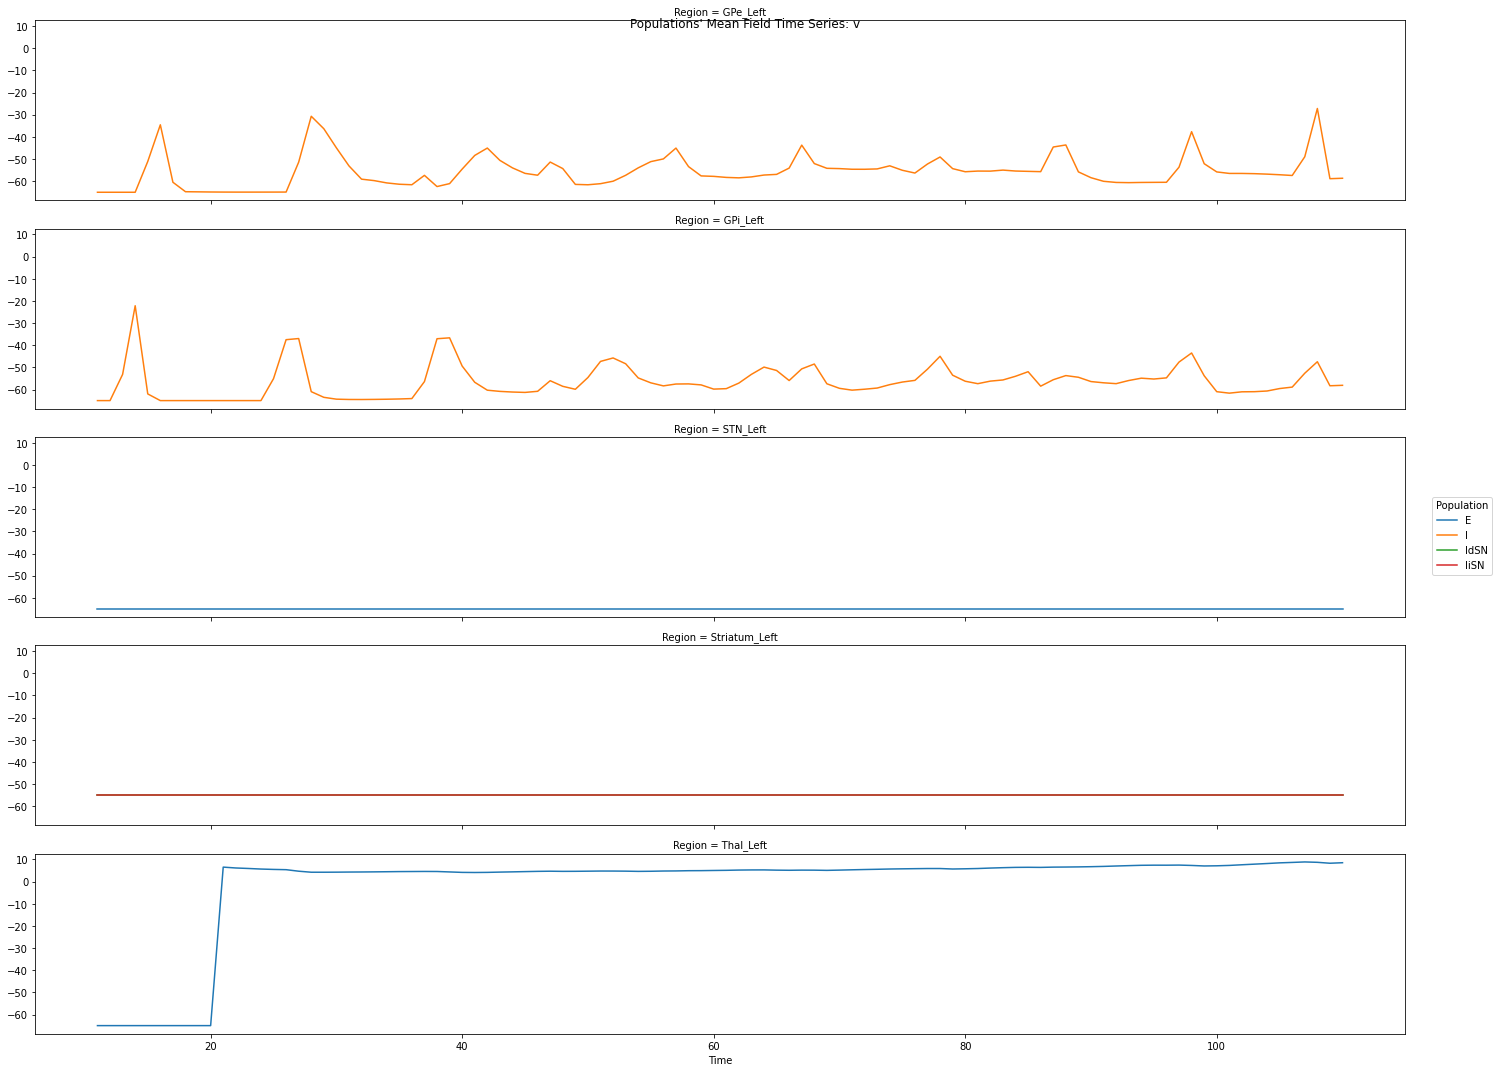

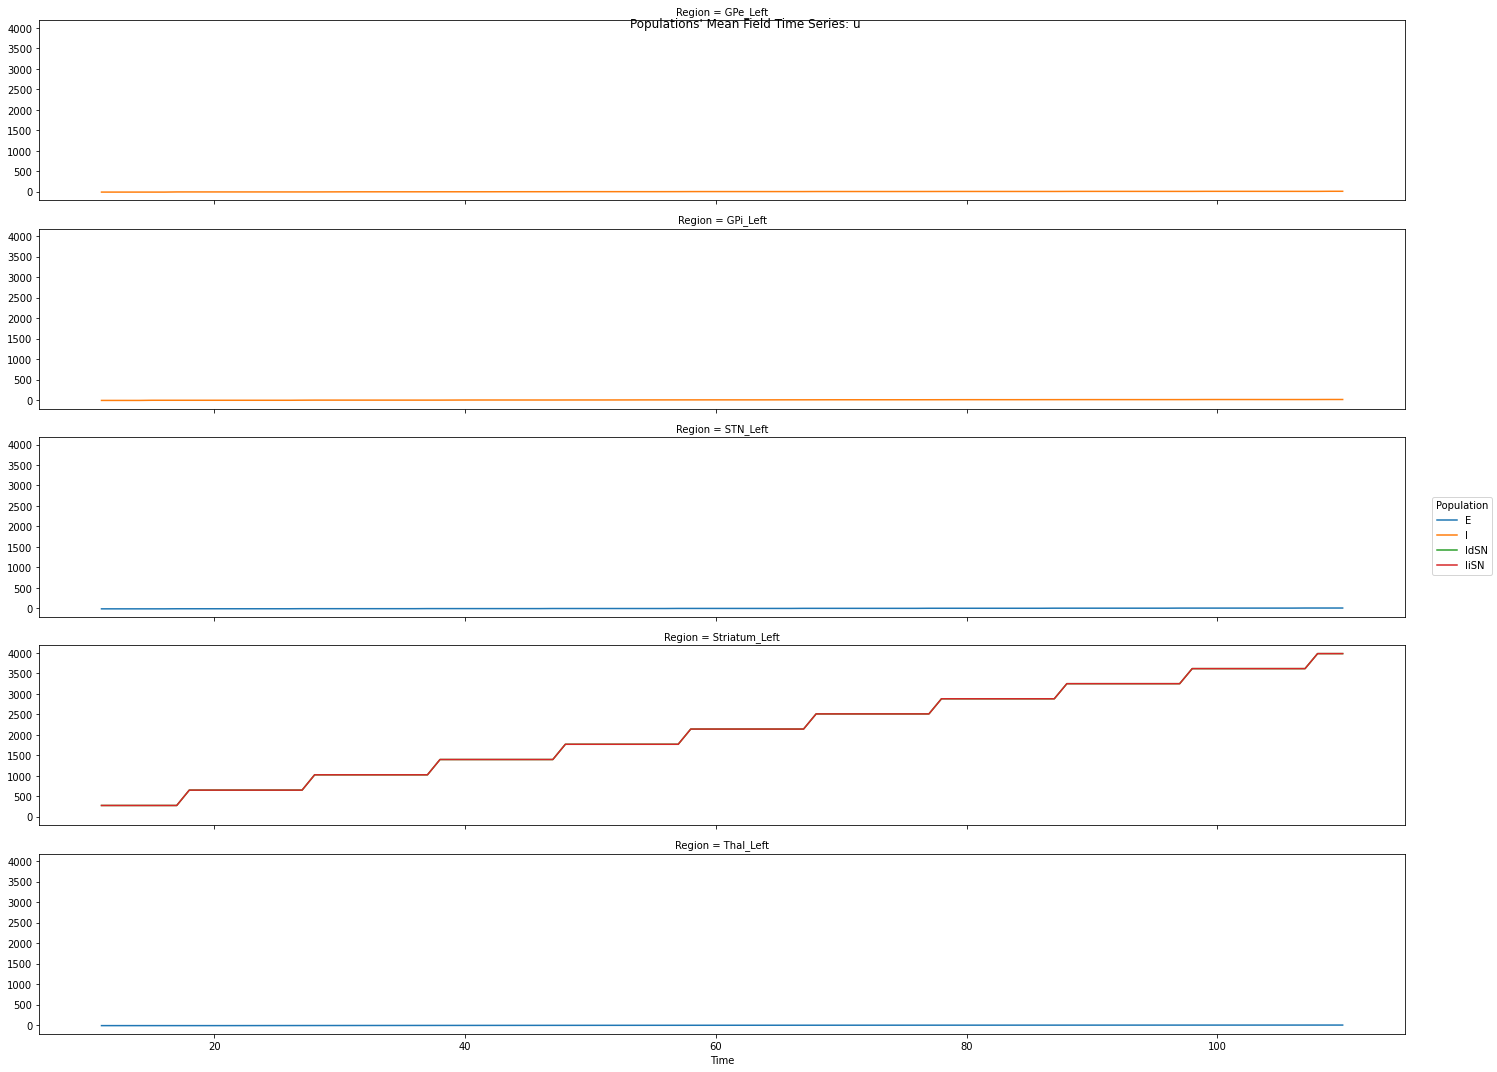

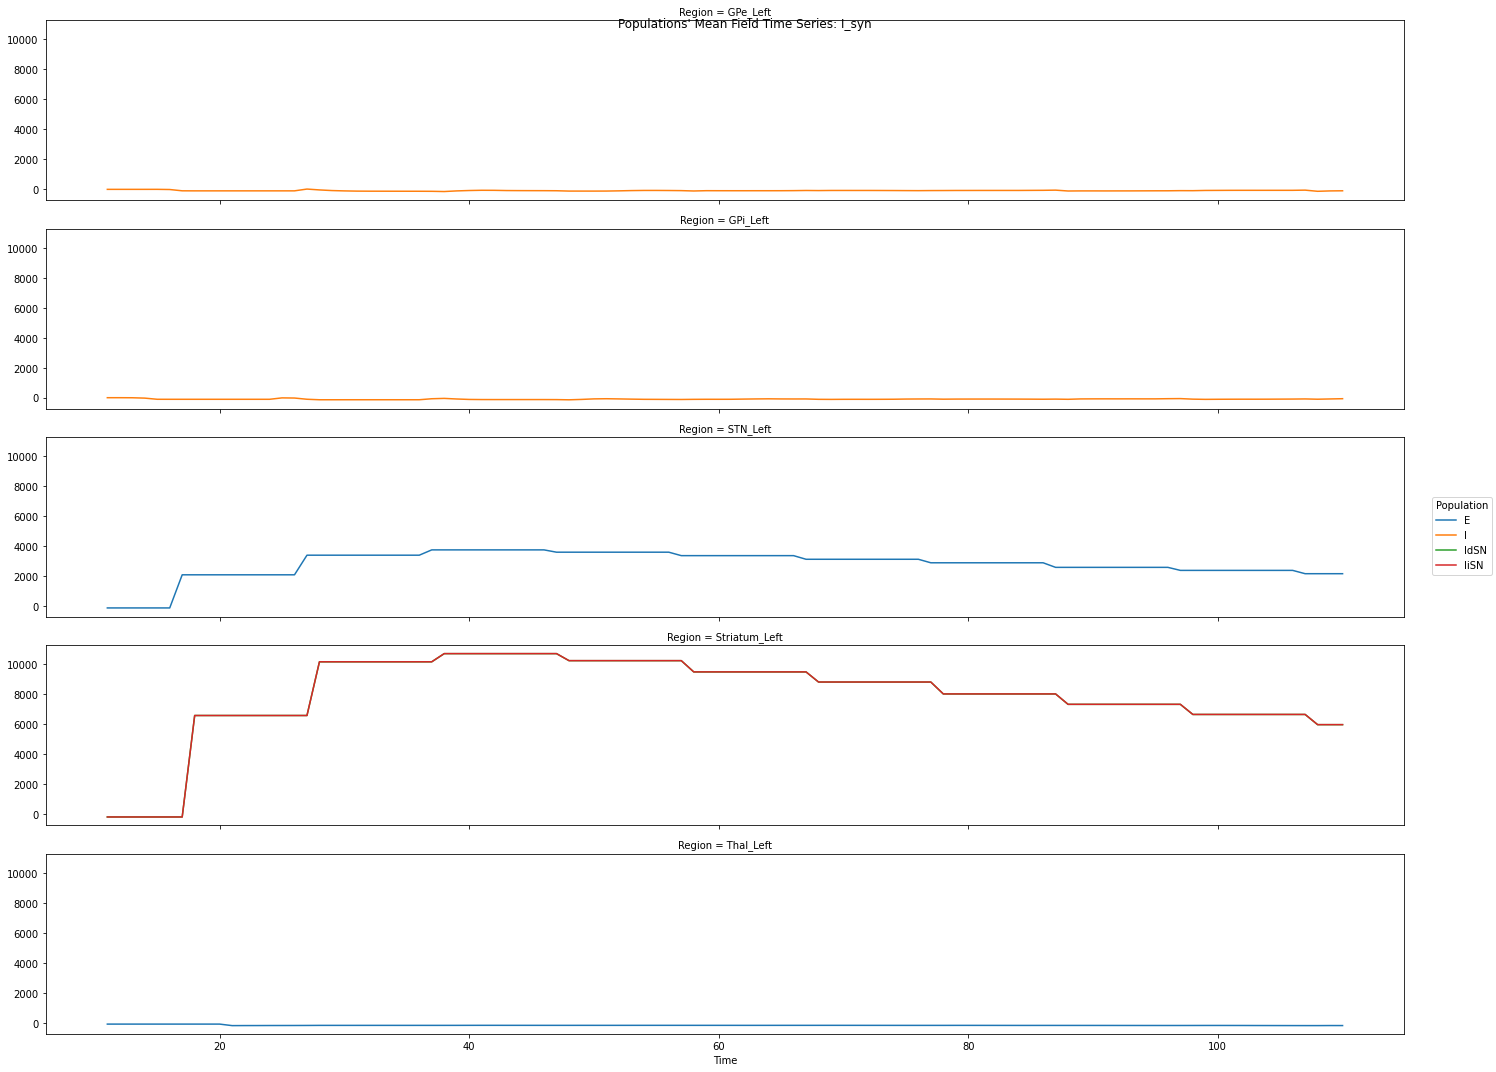

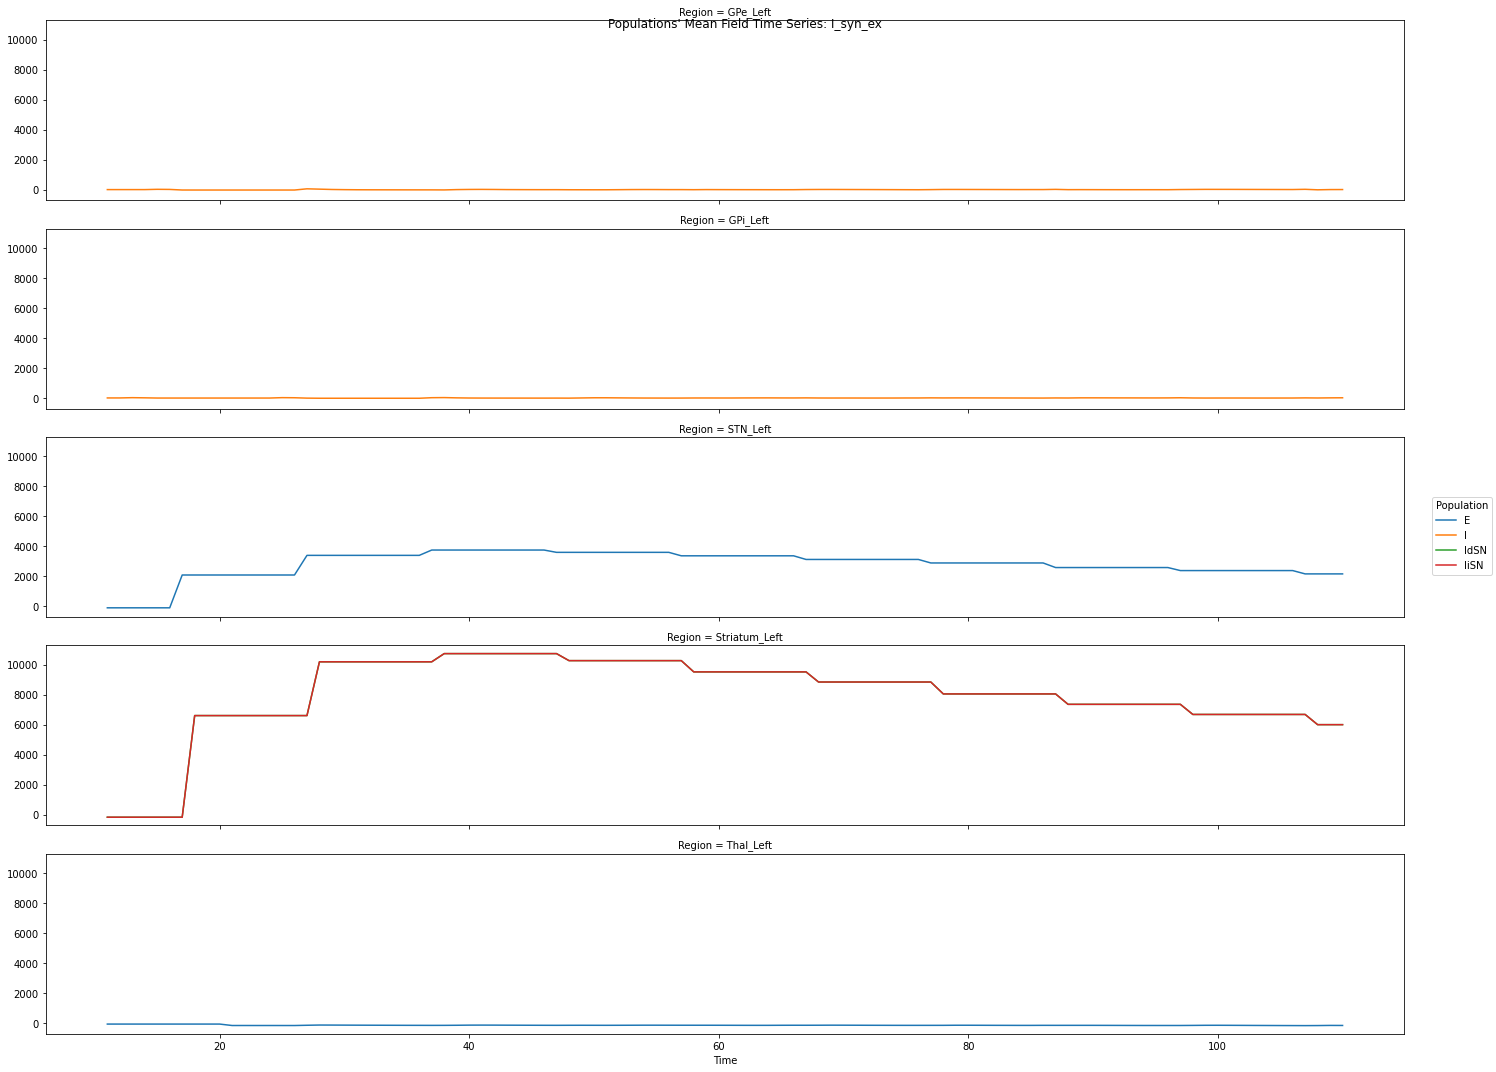

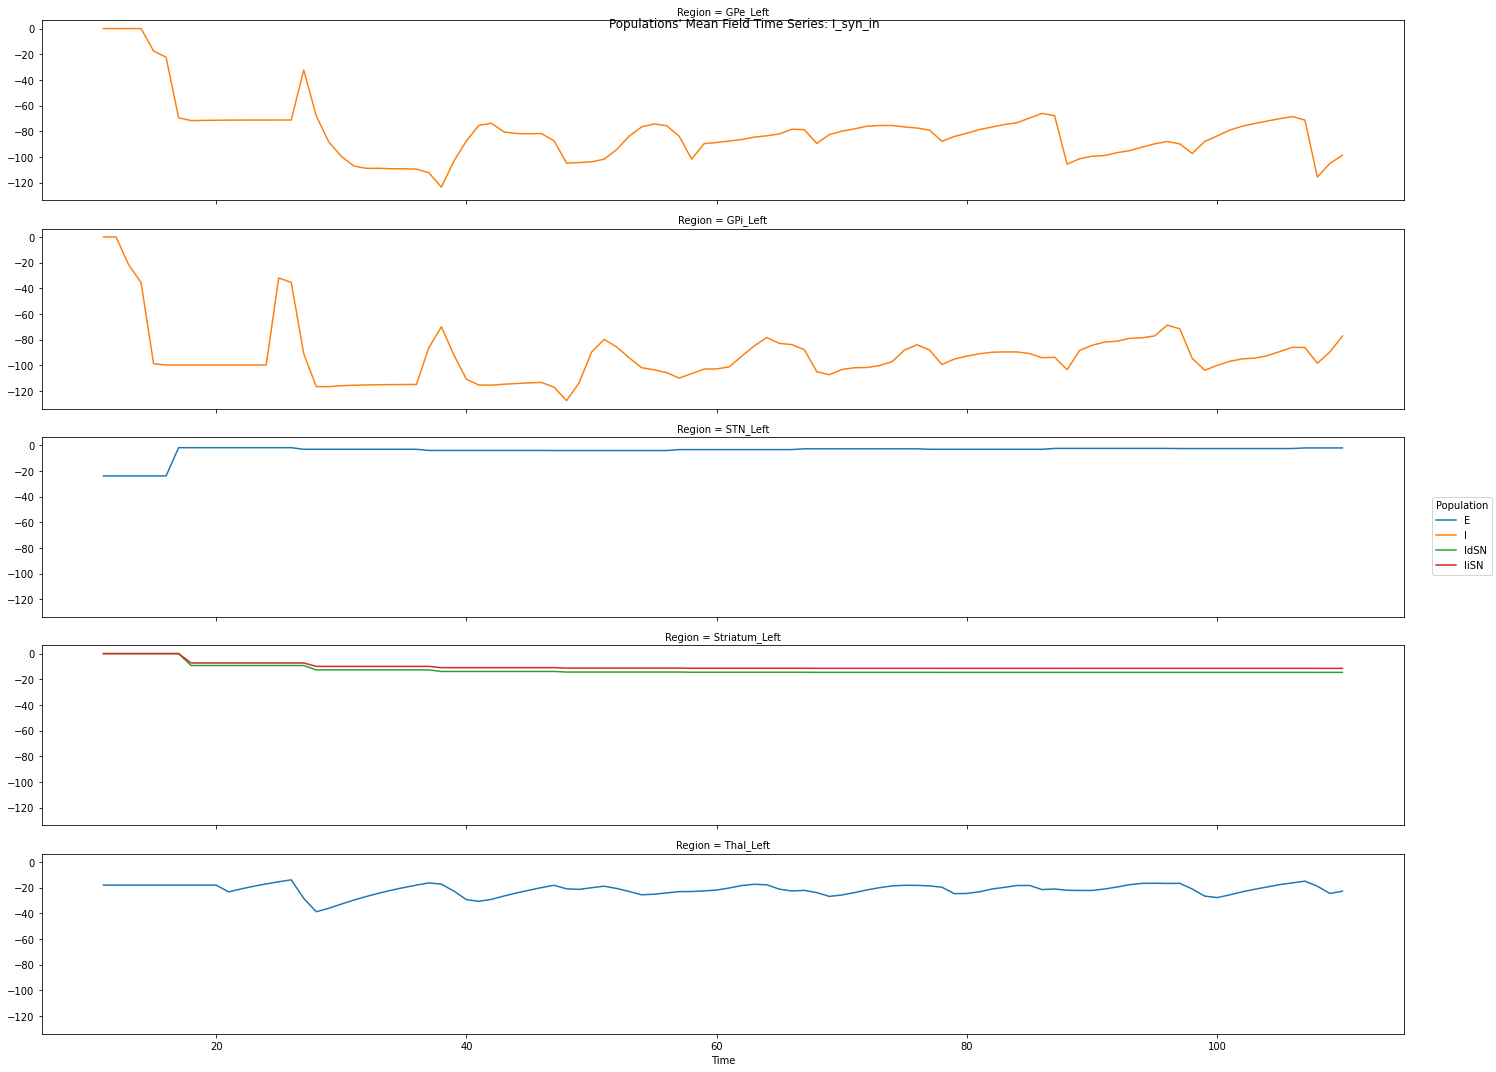

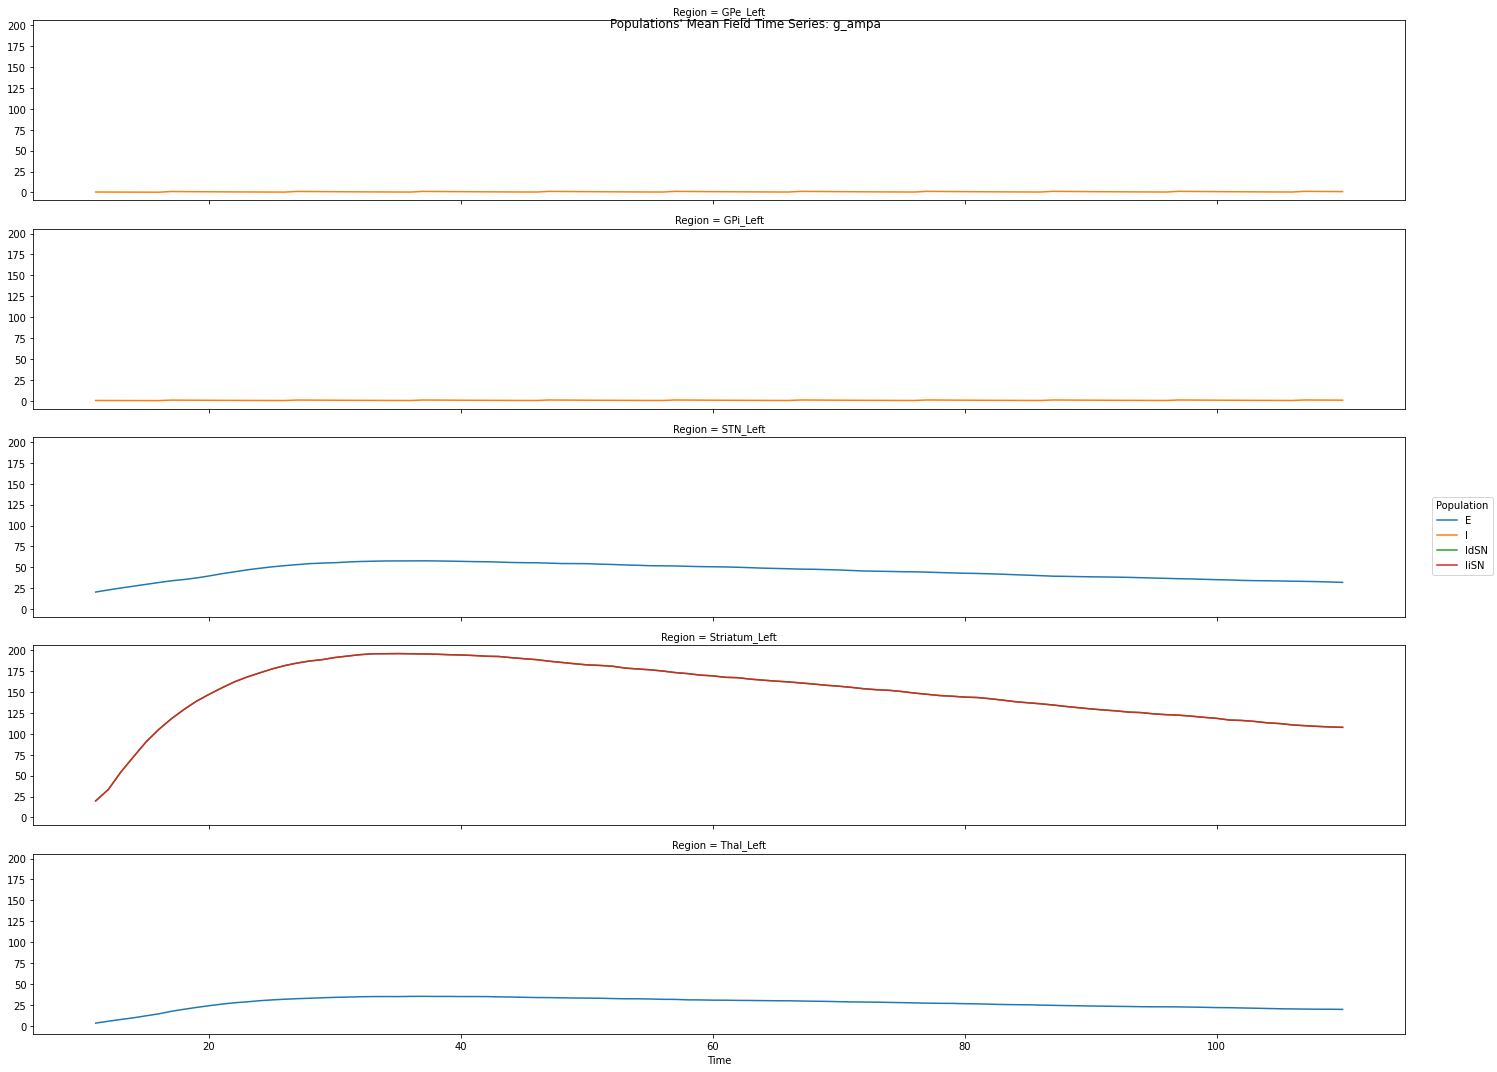

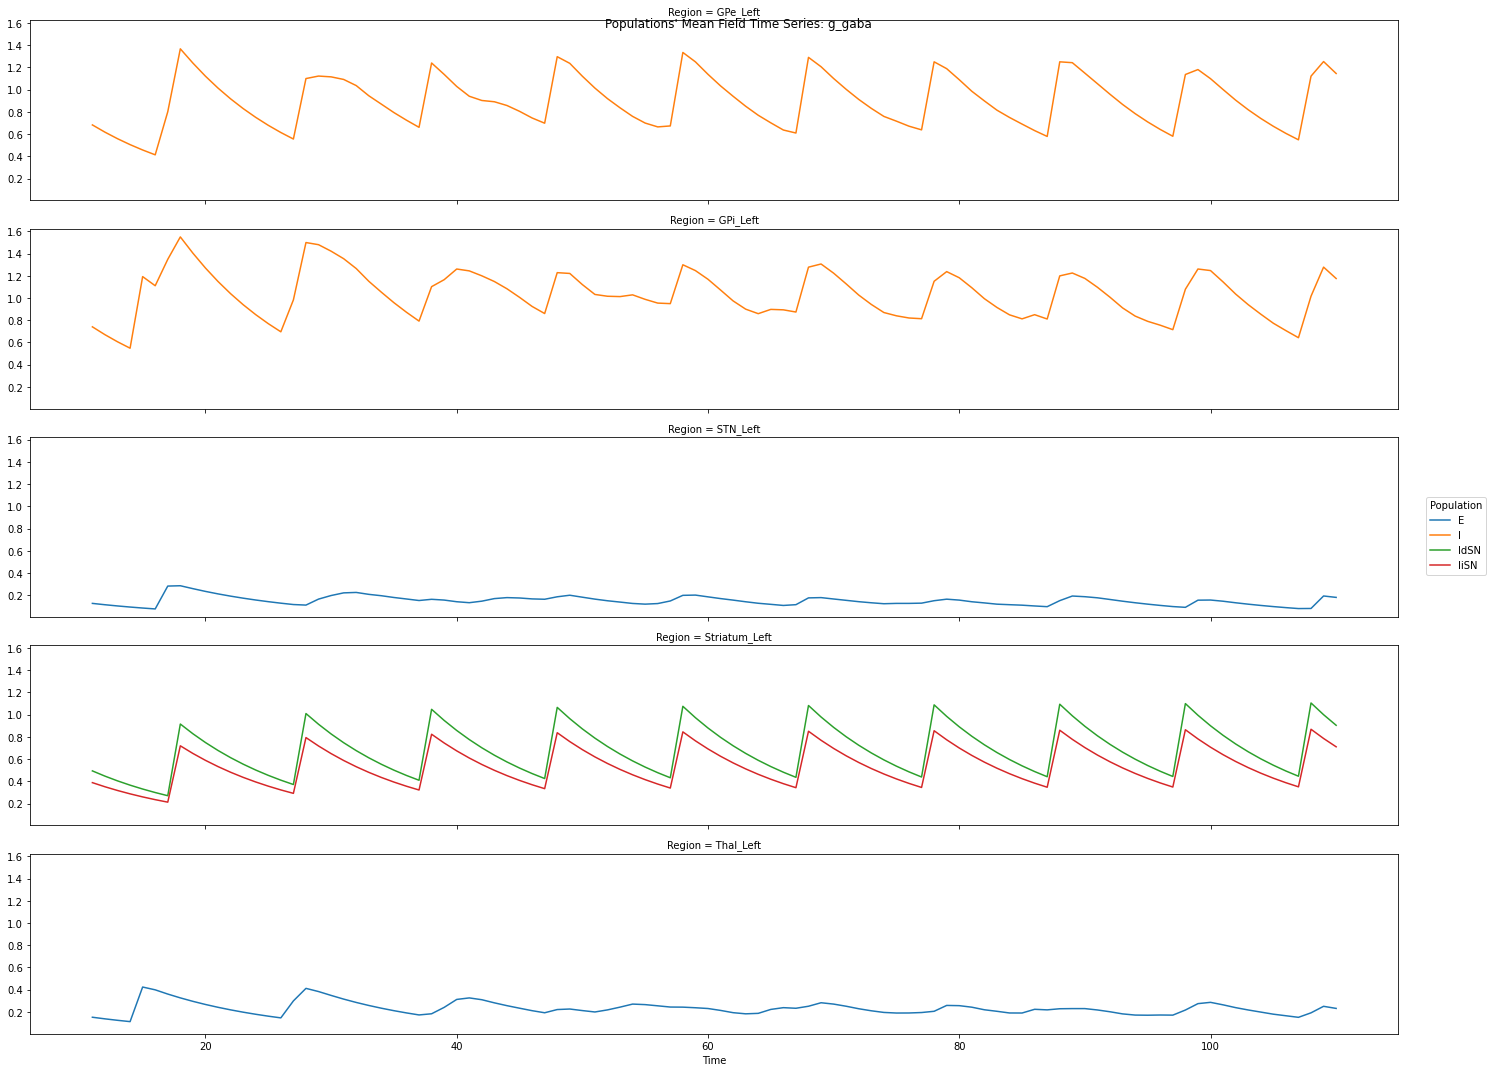

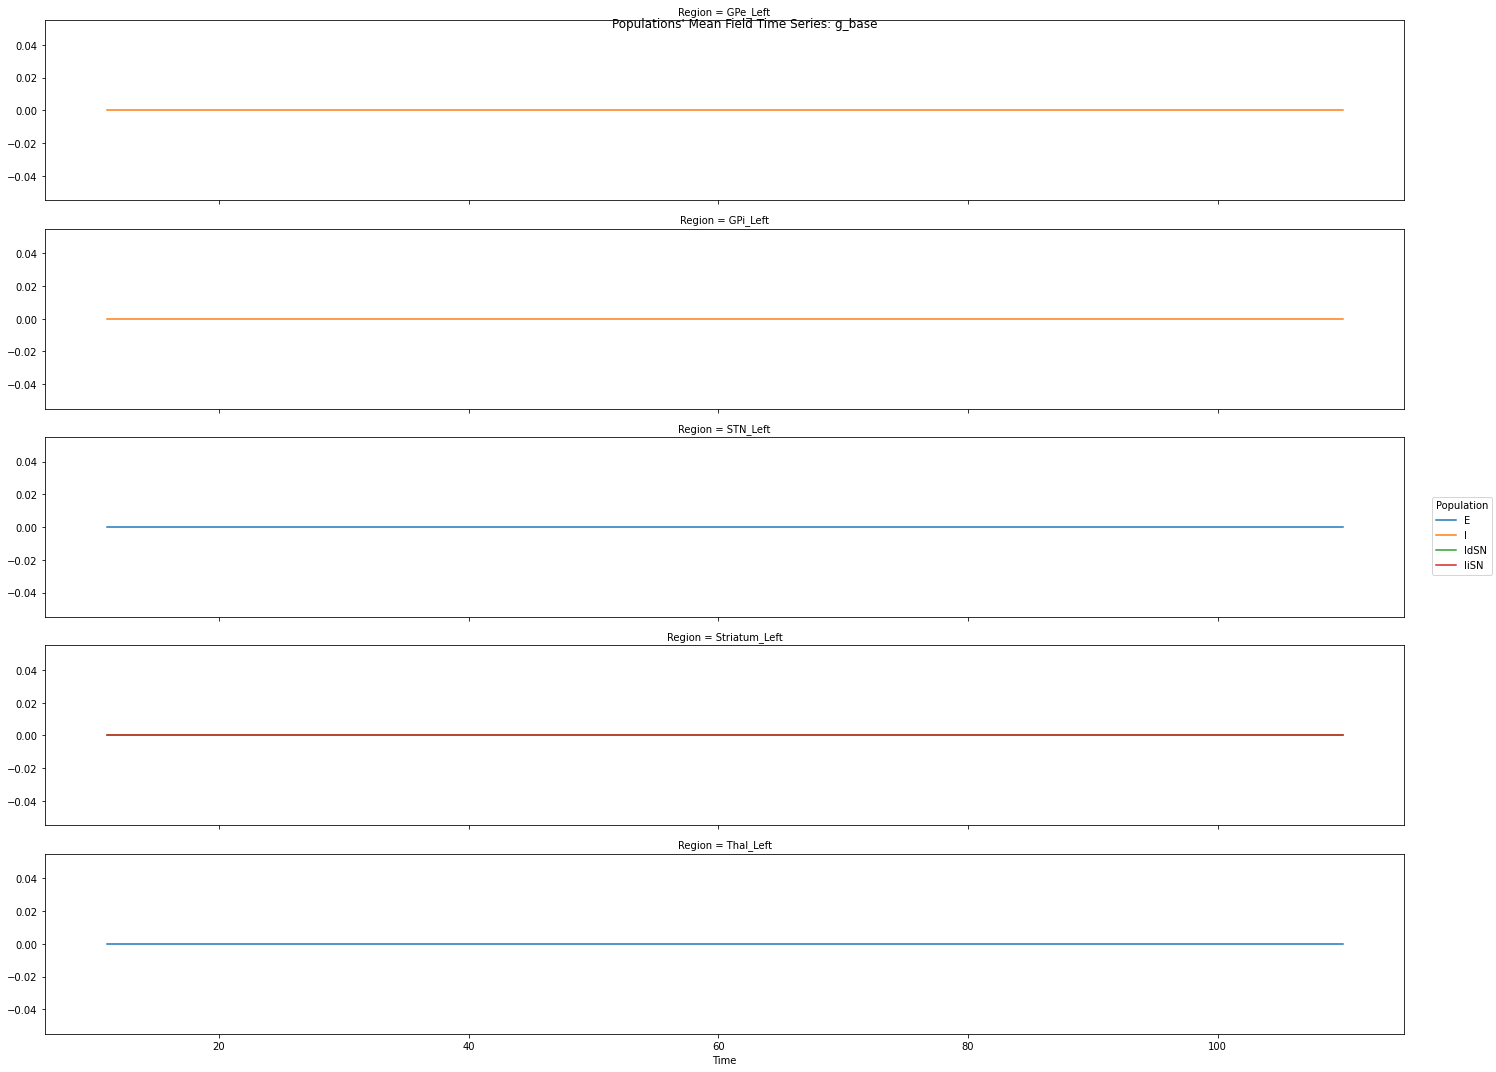

In [25]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [26]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [27]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [28]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Vitay J, Dinkelbach HÜ and Hamker FH (2015). <br>
  ANNarchy: a code generation approach to neural simulations on parallel hardware. <br>
  Frontiers in Neuroinformatics 9:19. doi:10.3389/fninf.2015.00019 <br>
  For more details see https://annarchy.readthedocs.io/en/latest/ <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868

In [29]:
tvb_annarchy_model.tvb_to_spikeNet_interfaces[0][0].device_ind

-1

In [30]:
from tvb_multiscale.tvb_annarchy.annarchy_models.builders.annarchy_factory import get_population_ind

In [31]:
get_population_ind(tvb_annarchy_model.tvb_to_spikeNet_interfaces[0][0]._population, tvb_annarchy_model.tvb_to_spikeNet_interfaces[0][0].annarchy_instance)

6